<a href="https://colab.research.google.com/github/Itamar-Horowitz/real-time-AutoDS/blob/main/AutoDS/Realtime_AutoDS_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AutoDS**

---

<font size = 4> Deep-STORM is a neural network capable of image reconstruction from high-density single-molecule localization microscopy (SMLM), first published in 2018 by [Nehme *et al.* in Optica](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-5-4-458). The architecture used here is a U-Net based network without skip connections. This network allows image reconstruction of 2D super-resolution images, in a supervised training manner. The network is trained using simulated high-density SMLM data for which the ground-truth is available. These simulations are obtained from random distribution of single molecules in a field-of-view and therefore do not imprint structural priors during training. The network output a super-resolution image with increased pixel density (typically upsampling factor of 8 in each dimension).

<font size = 4> AutoDS is an extension of Deep-STORM automating the reconstruction process and aleviating the need in human intervension. This is done by automatic detection of the experimental condition in the analyzed videos and automatic selection of a Deep-STORM model out of a set of pre-trained model for the data processing.

<font size = 4> Additionally, AutoDS pipeline splits each input frame into patches and enables processing of different regions in the field-of-view with different models. This mechanism led to an improvment in the reconstruction quality beyond the capabilities of Deep-STORM.


# **Before getting started**
---
<font size = 4> This notebook contains the code required only for inference of SMLM data using a set of pre-trained Deep-STORM models. For model training please follow this [link](https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/blob/main/AutoDS/AutoDS_training.ipynb).

# **Run configuration**
---
<font size = 4>**`Data_folder`:** This folder should contain the images that you want to use your trained network on for processing.

<font size = 4>**`Result_folder`:** This folder will contain the found localizations csv.

<font size = 4>**`threshold`:** This paramter determines threshold for local maxima finding. A higher `threshold` will result in less localizations. **DEFAULT: 10**

<font size = 4>**`neighborhood_size`:** This paramter determines size of the neighborhood within which the prediction needs to be a local maxima in recovery pixels (CCD pixel/upsampling_factor). A high `neighborhood_size` will make the prediction slower and potentially discard nearby localizations. **DEFAULT: 3**

<font size = 4>**`use_local_average`:** This paramter determines whether to locally average the prediction in a 3x3 neighborhood to get the final localizations. If set to **True** it will make inference slightly slower depending on the size of the FOV. **DEFAULT: True**

<font size = 4>**`num_patches`:** Determines the number of patches in each row and each column after splitting the frames to patches. The total number of patches will be num_patches<sup>2</sup>. **DEFAULT: 4**

<font size = 4>**`batch_size`:** This paramter determines how many frames are processed by any single pass on the GPU. A higher `batch_size` will make the prediction faster but will use more GPU memory. If an OutOfMemory (OOM) error occurs, decrease the `batch_size`. **DEFAULT: 1**

<font size = 4>**The following parameters are relevant only if `interpolate_based_on_imaging_parameters` is checked:**

<font size = 4> - **`pixel_size` [nm]:** the pixels size of the analyzed video. **DEFAULT: 107**

<font size = 4> - **`wavelength` [nm]:** the emission wavelength of the analyzed video. **DEFAULT: 715**

<font size = 4> - **`numerical_aperture`:** the optical setup numerical aperture of the analyzed video. **DEFAULT: 1.49**

<font size = 4> - **`chunk_size`:** determine the number of patches that will be analyzed in each prediction iteration. This parameter is used for managing compute resources in Google Colab. If you are facing crashes due to RAM memory limitation, decrease the number of patches per chunk. **DEFAULT: 10000**

# Download testing flie

In [52]:
Data_folder = "https://github.com/Itamar-Horowitz/real-time-AutoDS/tree/41c8f1af1c8e513cffc314e496424f642f0ddf92/dataset/TOM20_10nM/1" #@param {type:"string"}

def download_github_directory(repo_url, local_path, branch='main'):
    """
    Download all files from a GitHub directory
    Uses git clone with LFS support as primary method

    Args:
        repo_url: GitHub directory URL (e.g., https://github.com/user/repo/tree/branch/path/to/dir)
        local_path: Local directory to save files
        branch: Git branch name (default: 'main')
    """
    # Parse the GitHub URL
    parts = repo_url.split('github.com/')[-1].split('/')
    if len(parts) < 5:
        raise ValueError("Invalid GitHub directory URL")

    user = parts[0]
    repo = parts[1]

    # Find where the path starts (after 'tree' and branch/commit)
    if 'tree' in parts:
        tree_idx = parts.index('tree')
        path_parts = parts[tree_idx + 2:]  # Skip 'tree' and branch/commit
        dir_path = '/'.join(path_parts)
    else:
        dir_path = '/'.join(parts[3:])

    # Get the commit/branch from URL
    if 'tree' in parts:
        commit = parts[parts.index('tree') + 1]
    else:
        commit = branch

    # Method 2: Fall back to API-based download
    print("\nStart downloading data file")

    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{dir_path}?ref={commit}"

    try:
        req = urllib.request.Request(api_url, headers={'User-Agent': 'Mozilla/5.0'})
        with urllib.request.urlopen(req) as response:
            files_data = json.loads(response.read().decode())
    except Exception as e:
        return download_tiff_files_fallback(user, repo, commit, dir_path, local_path)

    os.makedirs(local_path, exist_ok=True)

    downloaded_files = []
    for item in files_data:
        if item['type'] == 'file':
            file_name = item['name']

            # Download TIFF, TIF, and ND2 files
            if file_name.lower().endswith(('.tif', '.tiff', '.nd2')):
                # Use raw.githubusercontent.com for binary files
                file_url = f"https://raw.githubusercontent.com/{user}/{repo}/{commit}/{dir_path}/{file_name}"
                dest_path = os.path.join(local_path, file_name)

                try:
                    download_github_file(file_url, dest_path, commit_or_branch=commit)
                    downloaded_files.append(dest_path)
                except Exception as e:
                    print(f"Failed to download {file_name}: {e}")
                    # Try using download_url from API as fallback
                    if 'download_url' in item and item['download_url']:
                        try:
                            download_github_file(item['download_url'], dest_path, commit_or_branch=commit)
                            downloaded_files.append(dest_path)
                        except Exception as e2:
                            print(f"Also failed with API URL: {e2}")

    return downloaded_files

# ============================================================================
# DOWNLOAD DATA FROM GITHUB
# ============================================================================
if Data_folder_URL.startswith('http'):
    downloaded_files = download_github_directory(Data_folder_URL, Data_folder)
else:
    log("Using local data folder (not downloading from GitHub)")
    Data_folder = Data_folder_URL


Start downloading data file
Saved to: https://github.com/Itamar-Horowitz/real-time-AutoDS/tree/41c8f1af1c8e513cffc314e496424f642f0ddf92/dataset/TOM20_10nM/1/High-density-frames_Image1_TOM20_10nM.tif (200.06 MB)


# **V1: Original TensorFlow Version**


[models] found: diff_1
[models] found: diff_2
[models] found: diff_3
[models] found: diff_4
--------------------------------
AutoDS installation complete.
You have GPU access
Tensorflow version is 2.19.0

Processing: High-density-frames_Image1_TOM20_10nM.tif (0.21 GB)
Loaded tiff stack with 400 frames
Splitting stack to patches and selecting Deep-STORM model



100%|██████████| 400/400 [00:59<00:00,  6.73it/s]


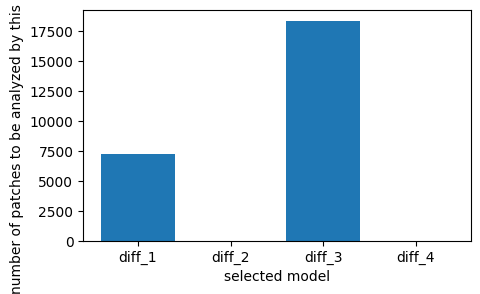

Analyzing patches for each model
The diff_1 model will be used.
Using local averaging
Result folder was created.
Reconstructing in chunks



100%|██████████| 1/1 [01:23<00:00, 83.04s/it]


The diff_2 model will be used.
Using local averaging
The diff_3 model will be used.
Using local averaging
Reconstructing in chunks



  0%|          | 0/2 [01:52<?, ?it/s]


KeyboardInterrupt: 

In [53]:
Notebook_version = '1.2'
Network = 'AutoDS'

# Import keras modules and libraries from tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, UpSampling2D, Conv2D, MaxPooling2D, BatchNormalization, Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

# Other libraries
import scipy.optimize as opt
import scipy.io as sio
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from numpy.lib.stride_tricks import sliding_window_view
from scipy.ndimage import gaussian_laplace, maximum_filter, binary_dilation
from scipy.signal import fftconvolve
from skimage.morphology import white_tophat, disk
import h5py
import cv2
from skimage import io
import sys, os, traceback
import csv
from PIL import Image
from PIL.TiffTags import TAGS
import math
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, zoom
from tqdm import tqdm
from contextlib import contextmanager
import time
from collections import defaultdict
from typing import Dict, List

# Create a variable to get and store relative base path
base_path = os.getcwd()

import io, json, zipfile, hashlib, shutil, urllib.request
from pathlib import Path

# ============================================================================
# TIMING PROFILER CLASS
# ============================================================================
class timing_profiler:
    def __init__(self, enabled=True):
        self.enabled = enabled
        self.accu_timing: Dict[str, List[float]] = defaultdict(list)
        self.active_timers: Dict[str, float] = {}

    def start_timer(self, name):
        if not self.enabled:
            return

        if tf.test.is_built_with_cuda() and len(tf.config.list_physical_devices('GPU')) > 0:
            # TensorFlow doesn't have synchronize like PyTorch, but we can use a dummy op
            _ = tf.constant(0)

        self.active_timers[name] = time.perf_counter()

    def stop_timer(self, name):
        if not self.enabled:
            return

        if tf.test.is_built_with_cuda() and len(tf.config.list_physical_devices('GPU')) > 0:
            _ = tf.constant(0)

        if name in self.active_timers:
            run_time = time.perf_counter() - self.active_timers[name]
            self.accu_timing[name].append(run_time)
            del self.active_timers[name]

    def get_stats(self, name):
        times = self.accu_timing[name]
        if not times:
            return {'total': 0, 'average': 0, 'count': 0, 'min': 0, 'max': 0}
        return {
            'total': sum(times),
            'average': sum(times) / len(times),
            'count': len(times),
            'min': min(times),
            'max': max(times)
        }

    def print_timing_summary(self):
        if not self.enabled:
            return

        sub_sections_timers = {}
        for name, times in self.accu_timing.items():
            sub_sections_timers[name] = times

        self._print_section(sub_sections_timers, "")

    def _print_section(self, timers, prefix):
        hierarchy = {}
        for name, times in timers.items():
            relative_name = name[len(prefix) + 1:] if name.startswith(prefix + '.') else name
            hierarchy[relative_name] = times

        if not hierarchy:
            return

        if 'total' in hierarchy:
            total_time = sum(hierarchy['total'])
        else:
            total_time = sum(sum(times) for times in hierarchy.values())

        print("-" * 84)
        print(f"{'Step':<40} {'total time':<12} {'avg (per call)':<8} {'calls':<8} {'% of total':<12}")
        print("-" * 84)

        sorted_items = sorted(hierarchy.items(), key=lambda x: sum(x[1]), reverse=True)

        for section_name, times in sorted_items:
            total = sum(times)
            avg_per_call = (total / len(times)) if times else 0
            count = len(times)
            percentage = (total / total_time * 100) if total_time > 0 else 0

            print(f"{section_name:<40} {total:>11.3f} {avg_per_call:>11.2f} {count:>7} {percentage:>10.1f}%")

    def reset(self):
        self.accu_timing.clear()
        self.active_timers.clear()

# Initialize global timing profiler
timing_prof = timing_profiler(enabled=True)

# ============================================================================
# GITHUB DATA DOWNLOAD UTILITIES
# ============================================================================
def download_github_file(url, destination, commit_or_branch='master'):
    """Download a single file from GitHub, handling Git LFS if needed"""
    # Convert GitHub web URL to raw content URL if needed
    if 'github.com' in url and '/blob/' in url:
        url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')

    os.makedirs(os.path.dirname(destination), exist_ok=True)

    # Add headers to avoid GitHub's HTML wrapper
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})

    with urllib.request.urlopen(req) as response:
        content = response.read()

        # Check if this is a Git LFS pointer file
        if b'version https://git-lfs.github.com/spec/' in content[:200]:
            # Parse LFS pointer to get actual file URL
            content_str = content.decode('utf-8')
            for line in content_str.split('\n'):
                if line.startswith('oid sha256:'):
                    oid = line.split(':')[1].strip()
                    # Extract user/repo and path from original URL
                    parts = url.split('/')
                    user = parts[3]
                    repo = parts[4]
                    commit = parts[5]  # Get commit from URL
                    file_path = '/'.join(parts[6:])

                    # Try multiple LFS URL formats
                    lfs_urls = [
                        f"https://media.githubusercontent.com/media/{user}/{repo}/{commit}/{file_path}",
                        f"https://github.com/{user}/{repo}/raw/{commit}/{file_path}?raw=true",
                        f"https://github.com/{user}/{repo}/blob/{commit}/{file_path}?raw=true",
                    ]

                    # Try each URL
                    for lfs_url in lfs_urls:
                        try:
                            req_lfs = urllib.request.Request(lfs_url, headers={
                                'User-Agent': 'Mozilla/5.0',
                                'Accept': 'application/vnd.git-lfs+json'
                            })
                            with urllib.request.urlopen(req_lfs) as lfs_response:
                                content = lfs_response.read()
                                # Check if we still got an LFS pointer
                                if b'version https://git-lfs.github.com/spec/' not in content[:200]:
                                    break
                        except Exception as e:
                            print(f"    Failed: {e}")
                            continue
                    break

        # Write content to file
        with open(destination, 'wb') as out_file:
            out_file.write(content)

    # Verify file was downloaded correctly
    file_size = os.path.getsize(destination)
    if file_size < 1000:  # Files smaller than 1KB are likely error pages
        with open(destination, 'rb') as f:
            content_check = f.read(100)
            if b'<!DOCTYPE' in content_check or b'<html' in content_check:
                raise ValueError(f"Downloaded HTML instead of binary file. URL may be incorrect.")
            elif b'version https://git-lfs.github.com/spec/' in content_check:
                raise ValueError(f"Still got LFS pointer file, not actual content.")

    print(f"Saved to: {destination} ({file_size / (1024*1024):.2f} MB)")


def download_tiff_files_fallback(user, repo, commit, dir_path, local_path):
    """Fallback method to download TIFF files when API fails"""
    os.makedirs(local_path, exist_ok=True)
    downloaded = []

    # Try common TIFF file numbering patterns
    for i in range(1, 100):  # Try up to 100 files
        for ext in ['.tif', '.tiff']:
            file_name = f"{i}{ext}"
            raw_url = f"https://raw.githubusercontent.com/{user}/{repo}/{commit}/{dir_path}/{file_name}"
            dest_path = os.path.join(local_path, file_name)

            try:
                urllib.request.urlretrieve(raw_url, dest_path)
                print(f"Downloaded: {file_name}")
                downloaded.append(dest_path)
                break  # Found file with this number, try next
            except:
                continue  # File doesn't exist, try next

        if i > 10 and len(downloaded) == 0:
            break  # Stop if first 10 attempts fail

    if len(downloaded) == 0:
        print("No files found with fallback method.")
    else:
        print(f"Downloaded {len(downloaded)} files using fallback method")

    return downloaded

# ============================================================================
# REST OF THE ORIGINAL CODE
# ============================================================================

def is_tiff(path):
    """Check if file is TIFF"""
    return path.lower().endswith(('.tif', '.tiff'))

def _printer():
    # use global log() if you defined QUIET/log earlier; else print
    return log if 'log' in globals() else print

def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def _download(url, dst_path):
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    _printer()(f"[models] downloading: {url}")
    urllib.request.urlretrieve(url, dst_path)

def _flatten_if_needed(target_dir, required_files):
    """
    If the extracted ZIP created a nested top-level folder (e.g., target_dir/diff_1/*),
    but we expect files directly under target_dir, move them up one level.
    """
    present = all(os.path.exists(os.path.join(target_dir, f)) for f in required_files)
    if present:
        return

    # look for a single subdir containing the stuff
    subdirs = [d for d in os.listdir(target_dir) if os.path.isdir(os.path.join(target_dir, d))]
    if len(subdirs) == 1:
        candidate = os.path.join(target_dir, subdirs[0])
        # if moving would fix it, move contents up
        if all(os.path.exists(os.path.join(candidate, f)) for f in required_files):
            for name in os.listdir(candidate):
                shutil.move(os.path.join(candidate, name), os.path.join(target_dir, name))
            # remove now-empty subdir
            try:
                os.rmdir(candidate)
            except OSError:
                pass

def ensure_models(model_names, target_root="/content/AutoDS_models", model_manifest=None):
    """
    model_manifest schema (choose ONE per model):
      # ZIP asset per model (recommended)
      {
        "diff_1": {
          "zip_url": "<direct zip url>",
          "sha256":  "<optional sha256 of the zip>",
          "contains": ["best_weights.h5", "model_metadata.mat"]
        },
        ...
      }

      # Raw files (no zip)
      {
        "diff_1": {
          "file_urls": {
            "best_weights.h5": "<direct file url>",
            "model_metadata.mat": "<direct file url>"
          },
          "file_sha256": {             # optional, per-file
            "best_weights.h5": "<sha256>",
            "model_metadata.mat": "<sha256>"
          },
          "contains": ["best_weights.h5", "model_metadata.mat"]
        },
        ...
      }
    """
    if model_manifest is None:
        raise ValueError("ensure_models: model_manifest must be provided.")
    os.makedirs(target_root, exist_ok=True)

    for m in model_names:
        cfg = model_manifest[m]
        mdir = os.path.join(target_root, m)
        need_fetch = False

        # fast-path: check presence
        req = cfg.get("contains", [])
        if not os.path.isdir(mdir):
            need_fetch = True
        else:
            for f in req:
                if not os.path.exists(os.path.join(mdir, f)):
                    need_fetch = True
                    break

        if not need_fetch:
            _printer()(f"[models] found: {m}")
            continue

        _printer()(f"[models] preparing: {m}")
        os.makedirs(mdir, exist_ok=True)

        if "zip_url" in cfg:
            # ZIP flow
            zip_url = cfg["zip_url"]
            zip_path = os.path.join(target_root, f"{m}.zip")
            _download(zip_url, zip_path)

            if "sha256" in cfg:
                digest = _sha256(zip_path)
                if digest != cfg["sha256"]:
                    raise ValueError(f"SHA256 mismatch for {m} zip. expected {cfg['sha256']} got {digest}")

            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(mdir)
            os.remove(zip_path)

            # handle nested folder cases
            _flatten_if_needed(mdir, req)

        elif "file_urls" in cfg:
            # Per-file flow
            file_urls = cfg["file_urls"]
            file_sha = cfg.get("file_sha256", {})
            for fname, url in file_urls.items():
                dst = os.path.join(mdir, fname)
                _download(url, dst)
                if fname in file_sha:
                    digest = _sha256(dst)
                    if digest != file_sha[fname]:
                        raise ValueError(f"SHA256 mismatch for {m}/{fname}. expected {file_sha[fname]} got {digest}")
        else:
            raise ValueError(f"Model {m} manifest must have either 'zip_url' or 'file_urls'.")

        # Final presence check
        for f in req:
            if not os.path.exists(os.path.join(mdir, f)):
                raise FileNotFoundError(f"Model {m} missing required file after fetch: {f}")

        _printer()(f"[models] ready: {m}")

    return target_root

# --- Quiet/Preview flags ------------------------------------------------------
QUIET = False            # no training/inference chatter unless set to False
HEADLESS_PREVIEW = True  # set True if you want to see the preview figures

def log(*args, **kwargs):
    if not QUIET:
        print(*args, **kwargs)

# Define where to fetch each model
# Replace the example zip URLs with your actual GitHub Release (or other) asset URLs.
model_names = ['diff_1', 'diff_2', 'diff_3', 'diff_4']
MODEL_MANIFEST = {
    "diff_1": {
        "file_urls": {
            "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_1/best_weights.h5",
            "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_1/model_metadata.mat",
        },
        "contains": ["best_weights.h5", "model_metadata.mat"]
    },
    "diff_2": {
        "file_urls": {
            "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_2/best_weights.h5",
            "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_2/model_metadata.mat",
        },
        "contains": ["best_weights.h5", "model_metadata.mat"]
    },
    "diff_3": {
        "file_urls": {
            "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_3/best_weights.h5",
            "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_3/model_metadata.mat",
        },
        "contains": ["best_weights.h5", "model_metadata.mat"]
    },
    "diff_4": {
        "file_urls": {
            "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_4/best_weights.h5",
            "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_4/model_metadata.mat",
        },
        "contains": ["best_weights.h5", "model_metadata.mat"]
    },
}
# Download (only if missing) and set prediction_model_path accordingly
prediction_model_path = ensure_models(model_names, target_root="/content/AutoDS_models", model_manifest=MODEL_MANIFEST)

def correctDriftLocalization(xc_array, yc_array, frames, xDrift, yDrift):
  n_locs = xc_array.shape[0]
  xc_array_Corr = np.empty(n_locs)
  yc_array_Corr = np.empty(n_locs)

  for loc in range(n_locs):
    xc_array_Corr[loc] = xc_array[loc] - xDrift[frames[loc] - 1]
    yc_array_Corr[loc] = yc_array[loc] - yDrift[frames[loc] - 1]

  return (xc_array_Corr, yc_array_Corr)

def FromLoc2Image_SimpleHistogram(xc_array, yc_array, image_size = (64,64), pixel_size = 100):
  w = image_size[0]
  h = image_size[1]
  locImage = np.zeros((image_size[0],image_size[1]) )
  n_locs = len(xc_array)

  for e in range(n_locs):
    locImage[int(max(min(round(yc_array[e]/pixel_size),w-1),0))][int(max(min(round(xc_array[e]/pixel_size),h-1),0))] += 1

  return locImage

def estimate_drift_com_nm(img1, img2, pixel_size_nm, sigma=1.0, patch_radius=3):
    # Smooth images
    img1_smooth = gaussian_filter(img1.astype(np.float32), sigma=sigma)
    img2_smooth = gaussian_filter(img2.astype(np.float32), sigma=sigma)

    # Cross-correlation
    corr = fftconvolve(img1_smooth, img2_smooth, mode='same')

    # Define center of the image
    center_y, center_x = np.array(corr.shape) // 2

    # Define a crop region around the center
    y_min = max(0, center_y - patch_radius)
    y_max = min(corr.shape[0], center_y + patch_radius + 1)
    x_min = max(0, center_x - patch_radius)
    x_max = min(corr.shape[1], center_x + patch_radius + 1)

    # Crop around center
    patch = corr[y_min:y_max, x_min:x_max]

    # Find subpixel center of mass in cropped patch
    y_grid, x_grid = np.meshgrid(
        np.arange(y_min, y_max), np.arange(x_min, x_max), indexing='ij'
    )

    total = np.sum(patch)
    if total == 0:
        return 0.0, 0.0

    y_com = np.sum(patch * y_grid) / total
    x_com = np.sum(patch * x_grid) / total

    # Drift relative to center, in pixels
    dy_px = y_com - center_y
    dx_px = x_com - center_x

    # Limit the drift to patch_radius
    if abs(dy_px) > patch_radius or abs(dx_px) > patch_radius:
        return 0.0, 0.0  # or raise an exception

    # Convert to nanometers
    dy_nm = dy_px * pixel_size_nm
    dx_nm = dx_px * pixel_size_nm

    return dy_nm, dx_nm

def gaussian_interpolation_batch(data_batch, scale, sigma=1):
    """
    Applies Gaussian interpolation (smoothing and upsampling) to a batch of images.

    Parameters:
    - data_batch: A numpy array of shape (batch_size, height, width), where each entry is an image.
    - scale: The scaling factor for upsampling.
    - sigma: The standard deviation for the Gaussian filter (default is 1).

    Returns:
    - upsampled_data_batch: A numpy array containing the upsampled images.
    """
    upsampled_data_batch = []

    for data in data_batch:
        # Apply Gaussian filter to each image in the batch
        smoothed_data = gaussian_filter(data, sigma=sigma)

        # Upsample the smoothed image
        upsampled_data = zoom(smoothed_data, scale, order=3)  # Using cubic interpolation for smooth upsampling
        upsampled_data_batch.append(upsampled_data)

    # Convert the list of upsampled images back into a numpy array
    return np.array(upsampled_data_batch)

def interpolate_frames(tiff_stack, model_pixel_size, current_pixel_size,
                             model_wavelength, current_wavelength, model_NA, current_NA):
    timing_prof.start_timer('interpolate_frames')

    # Compute ratio
    if model_pixel_size is None: model_pixel_size = current_pixel_size
    if model_wavelength is None: model_wavelength = current_wavelength
    if model_NA is None: model_NA = current_NA
    if current_wavelength is None: current_wavelength = model_wavelength = 1
    if current_NA is None: current_NA = model_NA = 1

    if len(tiff_stack.shape) == 2:
        tiff_stack = tiff_stack[None, :, :]

    scale_ratio_sq = (0.21 * model_wavelength / model_NA) ** 2 - (0.21 * current_wavelength / current_NA) ** 2
    if (scale_ratio_sq) > 0:
        scale_ratio = np.sqrt(scale_ratio_sq) / model_pixel_size
        interpolated_stack = np.stack([gaussian_filter(tiff_stack[i], scale_ratio) for i in range(tiff_stack.shape[0])])
    else:
        zoom_factors = (1, model_pixel_size / current_pixel_size, model_pixel_size / current_pixel_size)
        interpolated_stack = zoom(tiff_stack.astype(np.float32), zoom_factors, order=3)

    timing_prof.stop_timer('interpolate_frames')
    return interpolated_stack.astype(np.float32, copy=False)

def ChooseNetByDifficulty_2025(density, SNR):
    num_models = 4
    norm_density = np.max([np.min([int(np.round(2 * density)), num_models-1]), 0])
    norm_SNR = num_models - 1 - np.max([np.min([SNR//2, num_models - 1]), 0])
    return int(np.round((norm_SNR + norm_density) / 2))

def reconstruct_patches_2025(Images, patch_ind, frame_numbers, weights_file, num_patches, overlap, number_of_frames,
                             thresh=0.1, neighborhood_size=3, use_local_avg=False, upsampling_factor=8, pixel_size=None,
                             batch_size=1):
    timing_prof.start_timer('reconstruct_patches_2025')

    pixel_size_hr = pixel_size / upsampling_factor

    # Convert Images to float32 Tensor and move to GPU
    Images = tf.convert_to_tensor(Images, dtype=tf.float32)
    if Images.ndim == 2:
        Images = tf.expand_dims(Images, axis=0)  # Ensure 3D shape
    K_frames, M, N = Images.shape

    # Determine dimensions of each predicted (cropped) patch.
    patch_height = M * upsampling_factor - 2 * overlap
    patch_width = N * upsampling_factor - 2 * overlap

    # Create full image tensor on GPU
    reconstructed_image = np.zeros((patch_height * num_patches, patch_width * num_patches), dtype=np.float32)

    # Prepare lists for detections
    recon_xind, recon_yind, frame_index, confidence_list = [], [], [], []

    # Load the model on the GPU
    timing_prof.start_timer('model_loading')
    with tf.device('/GPU:0'):
        model = build_model_upsample((M, N, 1), lr=1e-3, upsampling_factor=upsampling_factor)
        model.load_weights(weights_file)

        # Create the post-processing layer
        max_layer = Maximafinder(thresh, neighborhood_size, use_local_avg)
    timing_prof.stop_timer('model_loading')

    timing_prof.start_timer('inference_patches')
    n_batches = int(np.ceil(K_frames / batch_size))
    for b in range(n_batches):
        start = b * batch_size
        end = min(K_frames, start + batch_size)
        nF = end - start

        # --- Move input batch to GPU ---
        batch_imgs = Images[start:end]  # Shape: (nF, M, N)

        # --- Run prediction on GPU ---
        predicted_density = model(batch_imgs, training=False)
        predicted_density = tf.nn.relu(predicted_density - 0.5).numpy()

        # Crop off extra overlap
        cropped_pred = predicted_density[:, overlap:-overlap, overlap:-overlap, 0]

        # --- Post-processing on GPU ---
        bind, xind, yind, conf = max_layer(predicted_density[:, overlap:-overlap, overlap:-overlap])

        # Convert tensors to NumPy (only when needed)
        bind_np, xind_np, yind_np, conf_np = bind.numpy(), xind.numpy(), yind.numpy(), conf.numpy() / L2_weighting_factor

        # --- Place each patch in reconstructed image ---
        for i in range(nF):
            p_ind = patch_ind[start + i]
            y1 = patch_height * (p_ind // num_patches)
            x1 = patch_width * (p_ind % num_patches)

            # Use TensorFlow addition instead of NumPy
            reconstructed_image[y1:y1 + patch_height, x1:x1 + patch_width] += (cropped_pred[i] / number_of_frames)

            # Collect detections
            det_idx = np.where(bind_np == i)[0]
            if det_idx.size:
                recon_xind.extend((x1 + xind_np[det_idx]).tolist())
                recon_yind.extend((y1 + yind_np[det_idx]).tolist())
                frame_index.extend([frame_numbers[start + i] + 1] * det_idx.size)
                confidence_list.extend(conf_np[det_idx].tolist())

    timing_prof.stop_timer('inference_patches')

    # Convert coordinates to physical units
    xind_final = (np.array(recon_xind) * pixel_size_hr).tolist()
    yind_final = (np.array(recon_yind) * pixel_size_hr).tolist()

    timing_prof.stop_timer('reconstruct_patches_2025')
    return reconstructed_image, [frame_index, xind_final, yind_final, confidence_list]


def split_image_to_patches(img, num_patches, overlap):
    timing_prof.start_timer('split_image_to_patches')

    # Determine the non-overlapping patch size.
    H, W = img.shape
    patch_h = H // num_patches
    patch_w = W // num_patches

    # Pad the image so that border patches have the proper overlap.
    padded_img = np.pad(img, ((overlap, overlap), (overlap, overlap)), mode='reflect')

    # Define the window (patch) shape including overlap.
    window_shape = (patch_h + 2 * overlap, patch_w + 2 * overlap)

    # Create a sliding window view of the padded image.
    patches_view = sliding_window_view(padded_img, window_shape)

    # Sample patches at strides equal to the basic patch size.
    patches_array = patches_view[0::patch_h, 0::patch_w, :, :]

    # Flatten the 2D grid of patches (row-major order) into a list.
    num_rows, num_cols, ph, pw = patches_array.shape
    patches_list = [patches_array[i, j].copy() for i in range(num_rows) for j in range(num_cols)]

    timing_prof.stop_timer('split_image_to_patches')
    return patches_list

def gauss2d(xy, offset, amp, x0, y0, sigma):
  x, y = xy
  return offset + (amp * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2) - ((y - y0) ** 2) / (2 * sigma ** 2)))

def extract_all_features(Images, FOV_size, pixel_size):
    timing_prof.start_timer('extract_all_features')

    M, N = FOV_size
    patch_size = 7
    xy = np.zeros([2, int(patch_size ** 2)])
    for i1 in range(patch_size):
        for j1 in range(patch_size):
            xy[:, int(i1 + patch_size * j1)] = [i1, j1]

    if(len(Images.shape) == 2):
        Images = Images[None, :, :]

    peaks_first_frame = peak_local_max(Images[0],
                                       min_distance=patch_size // 2,
                                       threshold_abs=np.mean(Images[0]) + np.std(Images[0]))
    peaks_for_analysis = []
    cnt = 0
    for i in range(len(peaks_first_frame)):
        if (np.sum(np.abs(peaks_first_frame[:, 0] - peaks_first_frame[i, 0]) +
                   np.abs(peaks_first_frame[:, 1] - peaks_first_frame[i, 1]) < 2) == 1):
            peaks_for_analysis.append([peaks_first_frame[cnt, 0], peaks_first_frame[cnt, 1]])
            cnt += 1
            if (cnt > 100):
                break

    peaks_for_analysis = np.array(peaks_for_analysis)
    number_of_PSFs_to_fit = np.min([100, peaks_for_analysis.shape[0]])

    sigmas_list = []
    gaussian_amp_list = []
    for i in range(number_of_PSFs_to_fit):
        down = np.max([0, peaks_for_analysis[i, 0] - patch_size // 2])
        up = np.min([M - 1, peaks_for_analysis[i, 0] + patch_size // 2])
        left = np.max([0, peaks_for_analysis[i, 1] - patch_size // 2])
        right = np.min([N - 1, peaks_for_analysis[i, 1] + patch_size // 2])
        zobs = (Images[0][down:up + 1, left:right + 1]).reshape(1, -1).squeeze()
        try:
            guess = [np.median(zobs), np.median(zobs), patch_size // 2, patch_size // 2, 1]
            bounds = ([0, 0, 0, 0, 0.5], [np.inf, np.inf, patch_size, patch_size, patch_size // 2])
            pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess, bounds=bounds)
        except Exception as e:
            continue
        fit = gauss2d(xy, *pred_params)
        if (1 - np.sqrt(np.mean((zobs / np.max(zobs) - fit / np.max(fit)) ** 2)) < 0.9):
           continue
        sigmas_list.append(pred_params[4])
        gaussian_amp_list.append(pred_params[1])

    if(len(sigmas_list) < 1):
        log("Did not find emitters for sigma estimation! setting sigma to 1 pixel")
        sigma = 1
        sigma_std = 0
    else:
        sigma = np.mean(sigmas_list)
        sigma_std = np.std(sigmas_list)

    mean_noise_list = []
    std_noise_list = []
    emitter_density_list = []
    for i in range(np.min([Images.shape[0], 100])):
        curr_mean_noise, curr_std_noise, signal_amp, curr_emitter_density = extract_features_frame(Images[i],
                                                                                                   pixel_size,
                                                                                                   verbose=False)
        mean_noise_list.append(curr_mean_noise)
        std_noise_list.append(curr_std_noise)
        emitter_density_list.append(curr_emitter_density)

    ADC_offset = np.mean(mean_noise_list)
    ReadOutNoise_ADC = np.mean(std_noise_list)
    gaussian_amp_mean = np.mean(gaussian_amp_list)
    gaussian_amp_std = np.std(gaussian_amp_list)
    emitter_density = np.mean(emitter_density_list)

    timing_prof.stop_timer('extract_all_features')
    return ADC_offset, ReadOutNoise_ADC, gaussian_amp_mean, gaussian_amp_std, \
           emitter_density, sigma, sigma_std

def remove_zero_padding(image):
    image_array = np.array(image)
    non_zero_rows = np.where(image_array.sum(axis=1) != 0)
    non_zero_cols = np.where(image_array.sum(axis=0) != 0)
    cropped_image = image_array[non_zero_rows[0][0]:non_zero_rows[0][-1]+1, non_zero_cols[0][0]:non_zero_cols[0][-1]+1]
    return cropped_image

def subtract_smooth_background(im, sigma=3):
    return im - gaussian_filter(im, sigma)

def subtract_background_tophat(im, radius=15):
    return white_tophat(im, footprint=disk(radius))

def extract_features_frame(OrigImage, pixel_size, psf_sigma, offset=None, verbose=False):
    M, N = OrigImage.shape

    Image = OrigImage - gaussian_filter(OrigImage, sigma=5)

    if(offset is not None):
        if(np.percentile(gaussian_filter(Image, 2), 99) < 2 * Image.mean() or np.percentile(OrigImage, 99) < 2 * offset):
            if(verbose):
                plt.figure(figsize=(7, 7))
                plt.title("SNR is too low - ignoring patch")
                plt.imshow(OrigImage)
                plt.show()
            return np.mean(OrigImage), np.std(OrigImage), 0, 0

    log_image = -gaussian_laplace(Image, sigma=psf_sigma)  # negative = blob-like peaks

    # Local maxima filtering
    neighborhood_size = 3
    local_max = (log_image == maximum_filter(log_image, size=neighborhood_size))

    # Compute the threshold
    amp_threshold = np.mean(Image) + 0.5 * (np.percentile(Image, 99) - np.mean(Image))

    # Apply intensity threshold
    pcntl_threshold = np.percentile(Image, 85)
    binary_mask = np.logical_and(local_max, Image > np.max([amp_threshold, pcntl_threshold]))

    dilated_mask = binary_dilation(binary_mask, structure=np.ones((5, 5)))
    noise_mask = np.ones_like(binary_mask)
    noise_mask[dilated_mask] = 0

    if(np.sum(binary_mask) > 0):
        ADC_offset = np.mean(OrigImage[noise_mask])
        ReadOutNoise_ADC = np.std(OrigImage[noise_mask])
        Signal_amp = np.mean(OrigImage[binary_mask == 1])
        emitter_density = (10 ** 6) * float(np.sum(binary_mask)) / (M * N * pixel_size ** 2)
    else:
        if(verbose):
            log("Didn't find any emitters")
        return np.mean(OrigImage), np.std(OrigImage), 0, 0

    if(Signal_amp / ADC_offset < 2.5):
        if(emitter_density > 2):
            if(verbose):
                plt.figure(figsize=(8, 8))
                plt.title("SNR is too low for emitter density estimation")
                plt.imshow(OrigImage)
                plt.show()

            return ADC_offset, ReadOutNoise_ADC, Signal_amp, 0

    if(verbose):
        plt.figure(figsize=(10, 5))
        plt.subplot(131)
        plt.imshow(OrigImage)
        plt.title("Offset = {}".format(offset))
        plt.subplot(132)
        plt.imshow(binary_mask)
        plt.title("signal mask - emitter density {:.3f}".format(emitter_density))
        plt.subplot(133)
        plt.imshow(noise_mask)
        plt.title("noise mask - SNR pred {:.3f}".format(Signal_amp / ADC_offset))
        plt.show()

    return ADC_offset, ReadOutNoise_ADC, Signal_amp, emitter_density

def project_01(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val)

def project_01_ret_vals(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val), min_val, max_val

def normalize_im(im, dmean, dstd):
    im = np.squeeze(im)
    return (im - dmean)/dstd

def conv_bn_relu(nb_filter, rk, ck, name):
    def f(input_tensor):
        conv = Conv2D(nb_filter, kernel_size=(rk, ck), strides=(1,1),
                      padding="same", use_bias=False,
                      kernel_initializer="Orthogonal", name='conv-'+name)(input_tensor)
        conv_norm = BatchNormalization(name='BN-'+name)(conv)
        conv_norm_relu = Activation("relu", name='Relu-'+name)(conv_norm)
        return conv_norm_relu
    return f

def CNN(input_tensor, names):
    Features1 = conv_bn_relu(32,3,3,names+'F1')(input_tensor)
    pool1 = MaxPooling2D(pool_size=(2,2), name=names+'Pool1')(Features1)
    Features2 = conv_bn_relu(64,3,3,names+'F2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name=names+'Pool2')(Features2)
    Features3 = conv_bn_relu(128,3,3,names+'F3')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2), name=names+'Pool3')(Features3)
    Features4 = conv_bn_relu(512,3,3,names+'F4')(pool3)
    up5 = UpSampling2D(size=(2, 2), name=names+'Upsample1')(Features4)
    Features5 = conv_bn_relu(128,3,3,names+'F5')(up5)
    up6 = UpSampling2D(size=(2, 2), name=names+'Upsample2')(Features5)
    Features6 = conv_bn_relu(64,3,3,names+'F6')(up6)
    up7 = UpSampling2D(size=(2, 2), name=names+'Upsample3')(Features6)
    Features7 = conv_bn_relu(32,3,3,names+'F7')(up7)
    return Features7

def buildModel(input_dim, initial_learning_rate=0.001):
    input_ = Input(shape=input_dim)
    act_ = CNN(input_, 'CNN')
    density_pred = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",
                           activation="linear", use_bias=False,
                           kernel_initializer="Orthogonal", name='Prediction')(act_)
    model = Model(inputs=input_, outputs=density_pred)
    opt = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt, loss=L1L2loss(input_dim))
    return model

def CNN_upsample(input, upsampling_factor):
    # Encoder
    x = Conv2D(32, (3, 3), padding='same', name="F1")(input)
    x = BatchNormalization(name="BN_1")(x)
    x = Activation('relu',name="ReLU_1")(x)

    x = Conv2D(64, (3, 3), padding='same', name="F2")(x)
    x = BatchNormalization(name="BN_2")(x)
    x = Activation('relu', name="ReLU_2")(x)

    x = Conv2D(128, (3, 3), padding='same', name="F3")(x)
    x = BatchNormalization(name="BN_3")(x)
    x = Activation('relu', name="ReLU_3")(x)

    x = Conv2D(256, (3, 3), padding='same', name="F4")(x)
    x = BatchNormalization(name="BN_4")(x)
    x = Activation('relu', name="ReLU_4")(x)

    # Decoder
    x = Conv2D(128, (3, 3), padding='same', name="F5")(x)
    x = BatchNormalization(name="BN_5")(x)
    x = Activation('relu', name="ReLU_5")(x)

    x = Conv2D(64, (3, 3), padding='same', name="F6")(x)
    x = BatchNormalization(name="BN_6")(x)
    x = Activation('relu', name="ReLU_6")(x)

    for ind, scale in enumerate(range(int(np.log2(upsampling_factor)))):
        x = UpSampling2D(size=(2, 2), interpolation='bilinear', name="upsample_{}".format(ind+1))(x)
        x = Conv2D(32, (5, 5), padding='same', name="conv_upsample{}".format(ind+1))(x)
        x = BatchNormalization(name="BN_upsample{}".format(ind+1))(x)
        x = Activation('relu', name="ReLU_upsample{}".format(ind+1))(x)

    return x

def build_model_upsample(input_shape, lr=0.001, upsampling_factor=2):
    input_ = Input(shape=input_shape)
    act_ = CNN_upsample(input_, upsampling_factor)
    density_pred = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",
                                  activation="linear", use_bias = False,
                                  kernel_initializer="Orthogonal",name='Prediction')(act_)
    model = Model(inputs= input_, outputs=density_pred)
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss = custom_loss(input_shape))
    return model

def custom_loss(input_shape):
    def loss_fn(y_true, y_pred):
        heatmap_pred = tf.nn.conv2d(y_pred, gfilter, strides=1, padding='SAME')
        loss_heatmaps = tf.reduce_mean(tf.square(y_true - heatmap_pred))
        loss_spikes = tf.reduce_mean(tf.abs(y_pred))
        return loss_heatmaps + loss_spikes

    return loss_fn

def matlab_style_gauss2D(shape=(7,7), sigma=1):
    m, n = [(ss-1.)/2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h = h.astype(K.floatx())
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h * 2.0
    h = h.astype('float32')
    return h

# Expand the filter dimensions
psf_heatmap = matlab_style_gauss2D(shape=(7,7), sigma=1)
gfilter = tf.reshape(psf_heatmap, [7, 7, 1, 1])

# Combined MSE + L1 loss
def L1L2loss(input_shape):
    def bump_mse(heatmap_true, spikes_pred):
        heatmap_pred = K.conv2d(spikes_pred, gfilter, strides=(1, 1), padding='same')
        loss_heatmaps = losses.mean_squared_error(heatmap_true, heatmap_pred)
        loss_spikes = losses.mean_absolute_error(spikes_pred, tf.zeros(input_shape))
        return loss_heatmaps + loss_spikes
    return bump_mse

def getPixelSizeTIFFmetadata(TIFFpath, display=False):
  with Image.open(TIFFpath) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

  ResolutionUnit = meta_dict['ResolutionUnit'][0]
  width = meta_dict['ImageWidth'][0]
  height = meta_dict['ImageLength'][0]
  xResolution = meta_dict['XResolution'][0]
  if len(xResolution) == 1:
    xResolution = xResolution[0]
  elif len(xResolution) == 2:
    xResolution = xResolution[0]/xResolution[1]
  else:
    log('Image resolution not defined.')
    xResolution = 1

  if ResolutionUnit == 2:
    pixel_size = 0.025*1e9/xResolution
  elif ResolutionUnit == 3:
    pixel_size = 0.01*1e9/xResolution
  else:
    log('Resolution unit not defined. Assuming: um')
    pixel_size = 1e3/xResolution

  if display:
    log('Pixel size obtained from metadata: '+str(pixel_size)+' nm')
    log('Image size: '+str(width)+'x'+str(height))

  return (pixel_size, width, height)

def saveAsTIF(path, filename, array, pixel_size):
  if (array.dtype == np.uint16):
    mode = 'I;16'
  elif (array.dtype == np.uint32):
    mode = 'I'
  else:
    mode = 'F'

  if len(array.shape) == 2:
    im = Image.fromarray(array)
    im.save(os.path.join(path, filename+'.tif'),
                  mode=mode,
                  resolution_unit=3,
                  resolution=0.01*1e9/pixel_size)
  elif len(array.shape) == 3:
    imlist = []
    for frame in array:
      imlist.append(Image.fromarray(frame))
    imlist[0].save(os.path.join(path, filename+'.tif'), save_all=True,
                  append_images=imlist[1:],
                  mode=mode,
                  resolution_unit=3,
                  resolution=0.01*1e9/pixel_size)
  return

class Maximafinder(Layer):
    def __init__(self, thresh, neighborhood_size, use_local_avg, **kwargs):
        super(Maximafinder, self).__init__(**kwargs)
        self.thresh = tf.constant(thresh, dtype=tf.float32)
        self.nhood = neighborhood_size
        self.use_local_avg = use_local_avg

    def build(self, input_shape):
        if self.use_local_avg:
          self.kernel_x = tf.reshape(tf.constant([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=tf.float32), [3, 3, 1, 1])
          self.kernel_y = tf.reshape(tf.constant([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=tf.float32), [3, 3, 1, 1])
          self.kernel_sum = tf.reshape(tf.constant([[1,1,1],[1,1,1],[1,1,1]], dtype=tf.float32), [3, 3, 1, 1])

    def call(self, inputs):
        max_pool_image = MaxPooling2D(pool_size=(self.nhood,self.nhood), strides=(1,1), padding='same')(inputs)
        cond = tf.math.greater(max_pool_image, self.thresh) & tf.math.equal(max_pool_image, inputs)
        indices = tf.where(cond)
        bind, xind, yind = indices[:, 0], indices[:, 2], indices[:, 1]
        confidence = tf.gather_nd(inputs, indices)

        if self.use_local_avg:
          x_image = K.conv2d(inputs, self.kernel_x, padding='same')
          y_image = K.conv2d(inputs, self.kernel_y, padding='same')
          sum_image = K.conv2d(inputs, self.kernel_sum, padding='same')
          confidence = tf.cast(tf.gather_nd(sum_image, indices), dtype=tf.float32)
          x_local = tf.math.divide(tf.gather_nd(x_image, indices), tf.gather_nd(sum_image, indices))
          y_local = tf.math.divide(tf.gather_nd(y_image, indices), tf.gather_nd(sum_image, indices))
          xind = tf.cast(xind, dtype=tf.float32) + tf.cast(x_local, dtype=tf.float32)
          yind = tf.cast(yind, dtype=tf.float32) + tf.cast(y_local, dtype=tf.float32)
        else:
          xind = tf.cast(xind, dtype=tf.float32)
          yind = tf.cast(yind, dtype=tf.float32)

        return bind, xind, yind, confidence

    def get_config(self):
        base_config = super(Maximafinder, self).get_config()
        config = {}
        return dict(list(base_config.items()) + list(config.items()))

def iter_tiff_frames(path):
    """Yield frames (float32 HxW) and return total count at the end."""
    with tiff.TiffFile(path) as tif:
        number_of_frames = len(tif.pages)
        for page in tif.pages:
            yield page.asarray().astype(np.float32)

def count_tiff_frames(path):
    with tiff.TiffFile(path) as tif:
        return len(tif.pages)

def is_nd2(path: str) -> bool:
    try:
        import nd2
        return nd2.is_supported_file(path)
    except Exception:
        return path.lower().endswith(".nd2")

def count_nd2_frames(path: str) -> int:
    import nd2
    with nd2.ND2File(path) as f:
        try:
            return len(f.loop_indices)
        except Exception:
            sz = getattr(f, "sizes", {}) or {}
            prod = 1
            for ax in ("T", "Z", "C", "V"):
                prod *= int(sz.get(ax, 1))
            return prod

def _nd2_to_2d(arr, channel=None):
    import numpy as np
    a = np.asarray(arr)
    if a.ndim == 2:
        return a
    if a.ndim == 3:
        if a.shape[-1] in (1, 3, 4):
            idx = channel if (channel is not None and channel < a.shape[-1]) else 0
            return a[..., idx]
        if a.shape[0] in (1, 3, 4):
            idx = channel if (channel is not None and channel < a.shape[0]) else 0
            return a[idx, ...]
        return a.mean(axis=0)
    a = a.squeeze()
    return a if a.ndim == 2 else a.reshape(a.shape[-2], a.shape[-1])

def iter_nd2_frames(path: str, channel: int | None = None):
    import nd2, numpy as np
    n = count_nd2_frames(path)
    with nd2.ND2File(path) as f:
        for i in range(n):
            fr = f.read_frame(i)
            fr2d = _nd2_to_2d(fr, channel=channel)
            yield fr2d.astype(np.float32, copy=False)

def getPixelSizeND2metadata(path, display=False):
    import nd2
    with nd2.ND2File(path) as f:
        vox_um = getattr(f, "voxel_size", None)
        if vox_um is None:
            return None, None, None
        px_nm = vox_um[2] * 1e3
        try:
            h, w = f.shape[-2], f.shape[-1]
        except Exception:
            h = w = None
        if display:
            print(f"Pixel size (ND2): {px_nm:.2f} nm | image ~ {w}x{h}")
        return px_nm, w, h

def list_files_multi(directory, extensions):
    exts = {('.' + e.lower()) for e in extensions}
    for f in os.listdir(directory):
        if os.path.splitext(f)[1].lower() in exts:
            yield f

def list_files(directory, extension):
  return (f for f in os.listdir(directory) if f.endswith('.' + extension))

log('--------------------------------')
log('AutoDS installation complete.')

if tf.test.gpu_device_name() == '':
  log('You do not have GPU access.')
  log('Did you change your runtime?')
  log('If the runtime settings are correct then GPU might not be allocated to your session.')
  log('Expect slow performance. To access GPU try reconnecting later.')
else:
  log('You have GPU access')

log('Tensorflow version is ' + str(tf.__version__))

MAX_FILE_GB = 5.0

def _is_oom(exc: BaseException) -> bool:
    msg = (str(exc) or "").upper()
    return (
        isinstance(exc, tf.errors.ResourceExhaustedError) or
        isinstance(exc, MemoryError) or
        "OUT OF MEMORY" in msg or "OOM" in msg or
        exc.__class__.__name__ in {"_ArrayMemoryError"}
    )

@contextmanager
def catch_oom(phase: str, detail: str = "", on_oom="continue"):
    """
    Wrap any memory-heavy block. Prints a friendly message on OOM and continues.
    """
    try:
        yield
    except Exception as e:
        if _is_oom(e):
            print(f"\n⚠️  OOM while {phase}{(' - ' + detail) if detail else ''}.")
            print("   Tip: reduce chunk_size/batch_size/upsampling, or downsample input.")
            if isinstance(e, tf.errors.ResourceExhaustedError) and getattr(e, "message", None):
                print("   TensorFlow says:", e.message.splitlines()[0][:200])
            else:
                traceback.print_exc(limit=1, file=sys.stdout)
            if on_oom != "continue":
                raise
        else:
            raise

verbose = False

# ============================================================================
# MAIN PROCESSING WITH GITHUB DATA DOWNLOAD
# ============================================================================

# ------------------------------- User input -------------------------------
# Set to GitHub URL or local path
Result_folder = "/content/gdrive/MyDrive/AutoDS/Results/TOM20_10nM/V1"  #@param {type:"string"}

threshold = 10 #@param {type:"number"}
neighborhood_size = 3 #@param {type:"integer"}
use_local_average = True #@param {type:"boolean"}

num_patches = 8 #@param {type:"number"}
overlap = 4
batch_size = 32 #@param {type:"integer"}

interpolate_based_on_imaging_parameters = True #@param {type:"boolean"}
get_pixel_size_from_file = False #@param {type:"boolean"}
pixel_size = 233 #@param {type:"number"}
wavelength = 233 #@param {type:"number"}
numerical_aperture = 1.49 #@param {type:"number"}

chunk_size = 10000 #@param {type:"number"}

psf_sigma_nm = 0.21 * wavelength / numerical_aperture
psf_sigma_pixels = psf_sigma_nm / pixel_size

if get_pixel_size_from_file:
  pixel_size = None


# ============================================================================
# PROCESSING PIPELINE
# ============================================================================
timing_prof.start_timer('total_processing')

matfile = sio.loadmat(os.path.join(prediction_model_path, model_names[0], 'model_metadata.mat'))
try:
    model_wavelength = np.array(matfile['wavelength'].item())
except:
    model_wavelength = None
try:
    model_NA = np.array(matfile['numerical_aperture'].item())
except:
    model_NA = None
try:
    model_pixel_size = np.array(matfile['pixel_size'].item())
except:
    model_pixel_size = None

if os.path.isdir(Data_folder):
    for filename in list_files_multi(Data_folder, extensions=['tif','tiff','nd2']):
        timing_prof.start_timer(f'file_{filename}')

        if filename.lower().endswith('.nd2'):
            try:
                import nd2
            except Exception:
                get_ipython().system('pip install -q nd2')

        in_path = os.path.join(Data_folder, filename)

        # File size guard
        try:
            file_size_gb = os.path.getsize(in_path) / 1e9
            log(f"\nProcessing: {filename} ({file_size_gb:.2f} GB)")
            if file_size_gb > MAX_FILE_GB:
                print(f"\n⚠️  {filename}: {file_size_gb:.2f} GB > {MAX_FILE_GB:.2f} GB.")
                print("   Video size is too big, please use Google Colab Pro or run locally.")
                continue
        except Exception:
            pass

        # Resolve pixel size if requested
        if get_pixel_size_from_file:
            if is_tiff(in_path):
                with catch_oom("reading TIFF pixel size", filename):
                    pixel_size, _, _ = getPixelSizeTIFFmetadata(in_path, True)
            elif is_nd2(in_path):
                with catch_oom("reading ND2 pixel size", filename):
                    px_nm, _, _ = getPixelSizeND2metadata(in_path, True)
                    pixel_size = px_nm if px_nm is not None else pixel_size

        # Common model params
        upsampling_factor = np.array(matfile['upsampling_factor']).item()
        try:
            L2_weighting_factor = np.array(matfile['Normalization factor']).item()
        except:
            L2_weighting_factor = 100

        patches_list = [[] for _ in model_names]
        patch_indices_list = [[] for _ in model_names]
        frame_numbers = [[] for _ in model_names]

        # Choose reader & frame count
        timing_prof.start_timer('frame_loading')
        number_of_frames, frame_iter = None, None
        with catch_oom("opening stack", filename):
            if is_tiff(in_path):
                number_of_frames = count_tiff_frames(in_path)
                frame_iter = iter_tiff_frames(in_path)
                log(f'Loaded tiff stack with {number_of_frames} frames')
            elif is_nd2(in_path):
                number_of_frames = count_nd2_frames(in_path)
                frame_iter = iter_nd2_frames(in_path)
                log(f'Loaded ND2 stack with ~{number_of_frames} planes (T*Z*C)')
            else:
                log(f"Skipping unsupported file: {filename}")
        timing_prof.stop_timer('frame_loading')

        if frame_iter is None:
            print(f"⚠️  Skipping {filename} due to earlier error.")
            continue

        # Initialize sum image
        sum_image = None

        log('Splitting stack to patches and selecting Deep-STORM model')
        timing_prof.start_timer('patch_splitting')
        for i, frame in enumerate(tqdm(frame_iter, total=number_of_frames if number_of_frames else None)):

            if sum_image is None:
                with catch_oom("allocating preview buffer", f"{filename} sum_image"):
                    sum_image = np.zeros_like(frame, dtype=np.float32)
                    if sum_image is None:
                        print(f"⚠️  Skipping {filename}: failed to allocate preview buffer.")
                        break

            # Keep running average for preview
            with catch_oom("accumulating preview", f"{filename} frame {i}"):
                sum_image += frame.astype(np.float32) / max(1, number_of_frames or 1)

            # Interpolate to match model resolution
            with catch_oom("interpolating frame", f"{filename} frame {i}"):
                if interpolate_based_on_imaging_parameters:
                    frame_i = interpolate_frames(
                        frame,
                        model_pixel_size, pixel_size,
                        model_wavelength, wavelength,
                        model_NA, numerical_aperture
                    )[0]
                else:
                    frame_i = frame

            if 'frame_i' not in locals():
                continue

            M, N = frame_i.shape

            # Background subtraction + standardization
            fproc = np.asarray(frame_i, dtype=np.float32)
            p35   = np.percentile(fproc, 35)
            fproc = fproc - p35
            fproc = fproc - fproc.min()

            fmean = fproc.mean(dtype=np.float64)
            fstd  = fproc.std(dtype=np.float64) + 1e-6
            fproc = (fproc - fmean) / fstd

            # Split into patches
            with catch_oom("splitting into patches", f"{filename} frame {i}"):
                patches = split_image_to_patches(fproc, num_patches, overlap)
            if 'patches' not in locals():
                continue

            offset = fproc.mean()

            # Per-patch difficulty selection
            for m in range(num_patches):
                for n in range(num_patches):
                    down  = overlap if m == 0 else 0
                    up    = (M // num_patches) - overlap if m == num_patches - 1 else (M // num_patches)
                    left  = overlap if n == 0 else 0
                    right = (N // num_patches) - overlap if n == num_patches - 1 else (N // num_patches)

                    with catch_oom("extracting features", f"{filename} frame {i} patch ({m},{n})"):
                        outputs = extract_features_frame(
                            patches[m*num_patches+n][down:up, left:right],
                            pixel_size,
                            psf_sigma_pixels,
                            offset=offset,
                            verbose=verbose
                        )
                    if 'outputs' not in locals():
                        continue

                    curr_mean_noise, curr_std_noise, signal_amp, curr_emitter_density = outputs

                    if (signal_amp == 0 or curr_mean_noise == 0):
                        continue
                    if any(np.isnan(v) for v in (signal_amp, curr_mean_noise, curr_std_noise, curr_emitter_density)):
                        continue

                    difficulty_choice = ChooseNetByDifficulty_2025(curr_emitter_density, signal_amp/curr_mean_noise)
                    patches_list[difficulty_choice].append(patches[m*num_patches+n])
                    patch_indices_list[difficulty_choice].append(m*num_patches+n)
                    frame_numbers[difficulty_choice].append(i)

        timing_prof.stop_timer('patch_splitting')

        # Model histogram
        selected_model_hist = np.array([len(p) for p in patches_list], dtype=float)
        if HEADLESS_PREVIEW:
            with catch_oom("plotting model histogram", filename):
                plt.figure(figsize=(5, 3))
                plt.bar(np.arange(len(model_names)), selected_model_hist, width=0.8)
                plt.xticks(np.arange(len(model_names)), model_names)
                plt.xlabel('selected model')
                plt.ylabel('number of patches to be analyzed by this model')
                plt.show()

        # If nothing collected, skip reconstruction
        if sum(len(p) for p in patches_list) == 0:
            print(f"ℹ️  No usable patches for {filename}; skipping reconstruction.")
            continue

        # M,N from last frame_i
        patchwise_recon = np.zeros([M * upsampling_factor, N * upsampling_factor], dtype=np.float32)
        frame_number_list, x_nm_list, y_nm_list, confidence_au_list = [], [], [], []

        log('Analyzing patches for each model')
        timing_prof.start_timer('reconstruction_all_models')
        for model_num, model_name in enumerate(model_names):
            model_dir = os.path.join(prediction_model_path, model_name)
            if os.path.exists(model_dir):
                log(f"The {os.path.basename(model_dir)} model will be used.")
            else:
                log('!! WARNING: The chosen model does not exist !!')
                log('Please make sure you provide a valid model path before proceeding further.')

            if use_local_average:
                log('Using local averaging')

            if not os.path.exists(Result_folder):
                log('Result folder was created.')
                os.makedirs(Result_folder, exist_ok=True)

            if patches_list[model_num]:
                log("Reconstructing in chunks")
                total_chunks = (len(patches_list[model_num]) // chunk_size) + 1
                for chunk_num in tqdm(range(total_chunks)):
                    chunk_start = chunk_num * chunk_size
                    chunk_end = min((chunk_num + 1) * chunk_size, len(patches_list[model_num]))

                    if chunk_start >= chunk_end:
                        continue

                    with catch_oom("reconstructing chunk",
                                   detail=f"{model_name} [{chunk_start}:{chunk_end}] of {len(patches_list[model_num])}"):
                        pw_recon, loc_list = reconstruct_patches_2025(
                            patches_list[model_num][chunk_start:chunk_end],
                            patch_indices_list[model_num][chunk_start:chunk_end],
                            frame_numbers[model_num][chunk_start:chunk_end],
                            os.path.join(prediction_model_path, model_names[model_num], 'best_weights.h5'),
                            num_patches,
                            overlap * upsampling_factor,
                            number_of_frames,
                            threshold,
                            neighborhood_size=neighborhood_size,
                            use_local_avg=use_local_average,
                            upsampling_factor=upsampling_factor,
                            pixel_size=pixel_size,
                            batch_size=batch_size
                        )

                        if 'pw_recon' in locals() and pw_recon is not None:
                            frame_number_list += loc_list[0]
                            x_nm_list += loc_list[1]
                            y_nm_list += loc_list[2]
                            confidence_au_list += loc_list[3]

                            patchwise_recon[:M//num_patches*upsampling_factor*num_patches,
                                            :N//num_patches*upsampling_factor*num_patches] += pw_recon

        timing_prof.stop_timer('reconstruction_all_models')

        ext = '_avg' if use_local_average else '_max'
        base = os.path.splitext(filename)[0]

        # Save outputs
        with catch_oom("saving outputs", base):
            with open(os.path.join(Result_folder, f'Localizations_{base}{ext}.csv'), "w", newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['frame', 'x [nm]', 'y [nm]', 'confidence [a.u]'])
                sort_ind = np.argsort(frame_number_list)
                locs = list(zip(list(np.array(frame_number_list)[sort_ind]),
                                list(np.array(x_nm_list)[sort_ind]),
                                list(np.array(y_nm_list)[sort_ind]),
                                list(np.array(confidence_au_list)[sort_ind])))
                writer.writerows(locs)

            pw_recon_tif = np.copy(patchwise_recon)
            cap = np.percentile(pw_recon_tif, 99.5)
            pw_recon_tif[pw_recon_tif > cap] = cap
            saveAsTIF(Result_folder, f'Predicted_patchwise_{base}', pw_recon_tif, pixel_size/upsampling_factor)
        timing_prof.stop_timer('saving_results')

        log('--------------------------------------------------------------------')
        log('---------------------------- Previews ------------------------------')
        log('--------------------------------------------------------------------')
        if HEADLESS_PREVIEW:
            with catch_oom("plotting previews", filename):
                fig, axes = plt.subplots(1, 3, figsize=(20,16))
                axes[0].axis('off'); axes[0].imshow(sum_image); axes[0].set_title('Original', fontsize=15)
                axes[1].axis('off'); axes[1].imshow(patchwise_recon); axes[1].set_title('Prediction', fontsize=15)
                axes[2].axis('off'); axes[2].imshow(np.clip(patchwise_recon,
                                                            np.percentile(patchwise_recon, 1),
                                                            np.percentile(patchwise_recon, 99)))
                axes[2].set_title('Normalized Prediction', fontsize=15)
                plt.show()

timing_prof.stop_timer('total_processing')

# ============================================================================
# PRINT TIMING SUMMARY
# ============================================================================
log('\n' + '=' * 84)
log('TIMING SUMMARY')
log('=' * 84)
timing_prof.print_timing_summary()

# **V2: PyTorch Version**
1. full pyTorch compatibility
2. frame-wize preprocessing (instead of model-wize)

In [ ]:

import os
import urllib.request
from contextlib import contextmanager

import numpy as np
import tifffile as tiff
from PIL import Image
from PIL.TiffTags import TAGS

def log(*args, **kwargs):
    if not config.QUIET:
        print(*args, **kwargs)

def list_files_multi(directory, extensions):
    exts = {('.' + e.lower()) for e in extensions}
    for f in os.listdir(directory):
        if os.path.splitext(f)[1].lower() in exts:
            yield f

@contextmanager
def catch_oom(phase: str, detail: str = "", on_oom="continue"):
    """
    Wrap any memory-heavy block. Prints a friendly message on OOM and continues.
    on_oom: "continue" (default) just prints and returns; any other value re-raises.
    """
    try:
        yield
    except Exception as e:
        if _is_oom(e):
            print(f"\n⚠️  OOM while {phase}{(' - ' + detail) if detail else ''}.")
            print("   Tip: reduce chunk_size/batch_size/upsampling, or downsample input.")
            if isinstance(e, torch.cuda.OutOfMemoryError):
                # PyTorch OOM messages are in str(e) directly
                msg_line = str(e).splitlines()[0][:200]
                print("   PyTorch says:", msg_line)
            else:
                traceback.print_exc(limit=1, file=sys.stdout)
            if on_oom != "continue":
                raise
        else:
            # Non-OOM: re-raise so real bugs are visible
            raise

# ============================================================================
# 1. TIFF File Operations
# ============================================================================

def getPixelSizeTIFFmetadata(TIFFpath, display=False):
    """Extract pixel size from TIFF metadata"""
    with Image.open(TIFFpath) as img:
        meta_dict = {TAGS[key]: img.tag[key] for key in img.tag.keys()}

    ResolutionUnit = meta_dict['ResolutionUnit'][0]
    width = meta_dict['ImageWidth'][0]
    height = meta_dict['ImageLength'][0]
    xResolution = meta_dict['XResolution'][0]

    if len(xResolution) == 1:
        xResolution = xResolution[0]
    elif len(xResolution) == 2:
        xResolution = xResolution[0] / xResolution[1]
    else:
        print('Image resolution not defined.')
        xResolution = 1

    if ResolutionUnit == 2:
        pixel_size = 0.025 * 1e9 / xResolution
    elif ResolutionUnit == 3:
        pixel_size = 0.01 * 1e9 / xResolution
    else:
        print('Resolution unit not defined. Assuming: um')
        pixel_size = 1e3 / xResolution

    if display:
        print(f'Pixel size from metadata: {pixel_size} nm')
        print(f'Image size: {width}x{height}')

    return pixel_size, width, height

def saveAsTIF(path, filename, array, pixel_size):
    """Save array as TIFF with metadata"""
    if array.dtype == np.uint16:
        mode = 'I;16'
    elif array.dtype == np.uint32:
        mode = 'I'
    else:
        mode = 'F'

    if len(array.shape) == 2:
        im = Image.fromarray(array)
        im.save(os.path.join(path, filename + '.tif'),
               mode=mode,
               resolution_unit=3,
               resolution=0.01 * 1e9 / pixel_size)
    elif len(array.shape) == 3:
        imlist = []
        for frame in array:
            imlist.append(Image.fromarray(frame))
        imlist[0].save(os.path.join(path, filename + '.tif'),
                      save_all=True,
                      append_images=imlist[1:],
                      mode=mode,
                      resolution_unit=3,
                      resolution=0.01 * 1e9 / pixel_size)

def is_tiff(path):
    """Check if file is TIFF"""
    return path.lower().endswith(('.tif', '.tiff'))

def iter_tiff_frames(path):
    """Iterate over TIFF frames"""
    with tiff.TiffFile(path) as tif:
        for page in tif.pages:
            yield page.asarray().astype(np.float32)

def count_tiff_frames(path):
    """Count frames in TIFF file"""
    with tiff.TiffFile(path) as tif:
        return len(tif.pages)

# ============================================================================
# 2. ND2 File Operations
# ============================================================================

def is_nd2(path):
    """Check if file is ND2"""
    try:
        import nd2
        return nd2.is_supported_file(path)
    except Exception:
        return path.lower().endswith(".nd2")

def count_nd2_frames(path):
    """Count frames in ND2 file"""
    import nd2
    with nd2.ND2File(path) as f:
        try:
            return len(f.loop_indices)
        except Exception:
            sz = getattr(f, "sizes", {}) or {}
            prod = 1
            for ax in ("T", "Z", "C", "V"):
                prod *= int(sz.get(ax, 1))
            return prod

def _nd2_to_2d(arr, channel=None):
    """Convert ND2 frame to 2D"""
    a = np.asarray(arr)
    if a.ndim == 2:
        return a
    if a.ndim == 3:
        if a.shape[-1] in (1, 3, 4):
            idx = channel if (channel is not None and channel < a.shape[-1]) else 0
            return a[..., idx]
        if a.shape[0] in (1, 3, 4):
            idx = channel if (channel is not None and channel < a.shape[0]) else 0
            return a[idx, ...]
        return a.mean(axis=0)
    a = a.squeeze()
    return a if a.ndim == 2 else a.reshape(a.shape[-2], a.shape[-1])

def iter_nd2_frames(path, channel=None):
    """Iterate over ND2 frames"""
    import nd2
    n = count_nd2_frames(path)
    with nd2.ND2File(path) as f:
        for i in range(n):
            fr = f.read_frame(i)
            fr2d = _nd2_to_2d(fr, channel=channel)
            yield fr2d.astype(np.float32, copy=False)

def getPixelSizeND2metadata(path, display=False):
    """Extract pixel size from ND2 metadata"""
    import nd2
    with nd2.ND2File(path) as f:
        vox_um = getattr(f, "voxel_size", None)
        if vox_um is None:
            return None, None, None
        px_nm = vox_um[2] * 1e3
        try:
            h, w = f.shape[-2], f.shape[-1]
        except Exception:
            h = w = None
        if display:
            print(f"Pixel size (ND2): {px_nm:.2f} nm | image ~ {w}x{h}")
        return px_nm, w, h

# ============================================================================
# 3. Drift Correction Functions
# ============================================================================

def correctDriftLocalization(xc_array, yc_array, frames, xDrift, yDrift):
    """Apply drift correction to localizations"""
    n_locs = xc_array.shape[0]
    xc_array_Corr = np.empty(n_locs)
    yc_array_Corr = np.empty(n_locs)

    for loc in range(n_locs):
        xc_array_Corr[loc] = xc_array[loc] - xDrift[frames[loc] - 1]
        yc_array_Corr[loc] = yc_array[loc] - yDrift[frames[loc] - 1]

    return xc_array_Corr, yc_array_Corr

def FromLoc2Image_SimpleHistogram(xc_array, yc_array, image_size=(64, 64), pixel_size=100):
    """Convert localizations to histogram image"""
    w, h = image_size
    locImage = np.zeros(image_size)
    n_locs = len(xc_array)

    for e in range(n_locs):
        y_idx = int(max(min(round(yc_array[e] / pixel_size), w - 1), 0))
        x_idx = int(max(min(round(xc_array[e] / pixel_size), h - 1), 0))
        locImage[y_idx][x_idx] += 1

    return locImage

def estimate_drift_com_nm(img1, img2, pixel_size_nm, sigma=1.0, patch_radius=3):
    """Estimate drift using center of mass of cross-correlation"""
    from scipy.ndimage import gaussian_filter
    from scipy.signal import fftconvolve

    # Smooth images
    img1_smooth = gaussian_filter(img1.astype(np.float32), sigma=sigma)
    img2_smooth = gaussian_filter(img2.astype(np.float32), sigma=sigma)

    # Cross-correlation
    corr = fftconvolve(img1_smooth, img2_smooth, mode='same')

    # Center of image
    center_y, center_x = np.array(corr.shape) // 2

    # Crop around center
    y_min = max(0, center_y - patch_radius)
    y_max = min(corr.shape[0], center_y + patch_radius + 1)
    x_min = max(0, center_x - patch_radius)
    x_max = min(corr.shape[1], center_x + patch_radius + 1)

    patch = corr[y_min:y_max, x_min:x_max]

    # Center of mass
    y_grid, x_grid = np.meshgrid(
        np.arange(y_min, y_max), np.arange(x_min, x_max), indexing='ij'
    )

    total = np.sum(patch)
    if total == 0:
        return 0.0, 0.0

    y_com = np.sum(patch * y_grid) / total
    x_com = np.sum(patch * x_grid) / total

    # Drift in pixels
    dy_px = y_com - center_y
    dx_px = x_com - center_x

    if abs(dy_px) > patch_radius or abs(dx_px) > patch_radius:
        return 0.0, 0.0

    # Convert to nm
    dy_nm = dy_px * pixel_size_nm
    dx_nm = dx_px * pixel_size_nm

    return dy_nm, dx_nm

# ============================================================================
# 4. Model Download Utilities
# ============================================================================

def ensure_models(model_names, target_root="/content/AutoDS_models", model_manifest=None):
    if model_manifest is None:
        raise ValueError("model_manifest must be provided.")

    os.makedirs(target_root, exist_ok=True)

    for m in model_names:
        cfg = model_manifest[m]
        mdir = os.path.join(target_root, m)
        need_fetch = False

        req = cfg.get("contains", [])
        if not os.path.isdir(mdir):
            need_fetch = True
        else:
            for f in req:
                if not os.path.exists(os.path.join(mdir, f)):
                    need_fetch = True
                    break

        if not need_fetch:
            print(f"[models] found: {m}")
            continue

        print(f"[models] preparing: {m}")
        os.makedirs(mdir, exist_ok=True)

        if "file_urls" in cfg:
            file_urls = cfg["file_urls"]
            for fname, url in file_urls.items():
                dst = os.path.join(mdir, fname)
                print(f"[models] downloading: {url}")
                urllib.request.urlretrieve(url, dst)
        else:
            raise ValueError(f"Model {m} manifest must have 'file_urls'.")

        for f in req:
            if not os.path.exists(os.path.join(mdir, f)):
                raise FileNotFoundError(f"Model {m} missing required file: {f}")

        print(f"[models] ready: {m}")

    return target_root


import numpy as np
import scipy.optimize as opt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.ndimage import gaussian_filter, zoom
from scipy.ndimage import gaussian_laplace, maximum_filter, binary_dilation
import torch
import torch.nn.functional as F

# ============================================================================
# 1. Image Preprocessing Functions
# ============================================================================

def normalize_im_01(im):
    """Normalize image to [0, 1]"""
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val) / (max_val - min_val)

def normalize_im_01_ret_vals(im):
    """Normalize and return normalization parameters"""
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val) / (max_val - min_val), min_val, max_val

def normalize_im(im, dmean, dstd):
    """Normalize image with given mean and std"""
    im = np.squeeze(im)
    return (im - dmean) / dstd

def subtract_smooth_background(im, sigma=3):
    """Subtract smoothed background"""
    return im - gaussian_filter(im, sigma)

def remove_zero_padding(image):
    """Remove zero padding from image"""
    image_array = np.array(image)
    non_zero_rows = np.where(image_array.sum(axis=1) != 0)
    non_zero_cols = np.where(image_array.sum(axis=0) != 0)
    cropped_image = image_array[non_zero_rows[0][0]:non_zero_rows[0][-1]+1,
                                non_zero_cols[0][0]:non_zero_cols[0][-1]+1]
    return cropped_image

# ============================================================================
# 2. Patch Splitting
# ============================================================================

def split_image_to_patches(img, num_patches, overlap):
    """
    Split image into overlapping patches

    Args:
        img: Input image (H, W)
        num_patches: Number of patches per dimension
        overlap: Overlap size in pixels

    Returns:
        List of patches
    """
    H, W = img.shape
    patch_h = H // num_patches
    patch_w = W // num_patches

    # Pad image for border patches
    padded_img = np.pad(img, ((overlap, overlap), (overlap, overlap)), mode='reflect')

    # Window shape including overlap
    window_shape = (patch_h + 2 * overlap, patch_w + 2 * overlap)

    # Create sliding window view
    patches_view = sliding_window_view(padded_img, window_shape)

    # Sample at regular intervals
    patches_array = patches_view[0::patch_h, 0::patch_w, :, :]

    # Flatten to list
    num_rows, num_cols, ph, pw = patches_array.shape
    patches_list = [patches_array[i, j].copy()
                   for i in range(num_rows)
                   for j in range(num_cols)]

    return patches_list

# ============================================================================
# 3. Interpolation and Scaling
# ============================================================================

def gaussian_interpolation_batch(data_batch, scale, sigma=1):
    """Apply Gaussian interpolation to batch of images"""
    upsampled_data_batch = []

    for data in data_batch:
        smoothed_data = gaussian_filter(data, sigma=sigma)
        upsampled_data = zoom(smoothed_data, scale, order=3)
        upsampled_data_batch.append(upsampled_data)

    return np.array(upsampled_data_batch)

def interpolate_frames(tiff_stack, model_pixel_size, current_pixel_size,
                      model_wavelength, current_wavelength,
                      model_NA, current_NA):
    """Interpolate frames to match model parameters"""
    # Set defaults
    if model_pixel_size is None:
        model_pixel_size = current_pixel_size
    if model_wavelength is None:
        model_wavelength = current_wavelength
    if model_NA is None:
        model_NA = current_NA
    if current_wavelength is None:
        current_wavelength = model_wavelength = 1
    if current_NA is None:
        current_NA = model_NA = 1

    if len(tiff_stack.shape) == 2:
        tiff_stack = tiff_stack[None, :, :]

    # Compute scaling ratio based on optical parameters
    scale_ratio_sq = ((0.21 * model_wavelength / model_NA) ** 2 -
                     (0.21 * current_wavelength / current_NA) ** 2)

    if scale_ratio_sq > 0:
        scale_ratio = np.sqrt(scale_ratio_sq) / model_pixel_size
        interpolated_stack = np.stack([
            gaussian_filter(tiff_stack[i], scale_ratio)
            for i in range(tiff_stack.shape[0])
        ])
    else:
        zoom_factors = (1,
                       model_pixel_size / current_pixel_size,
                       model_pixel_size / current_pixel_size)
        interpolated_stack = zoom(tiff_stack.astype(np.float32),
                                 zoom_factors, order=3)

    return interpolated_stack.astype(np.float32, copy=False)

# ============================================================================
# 4. Feature Extraction
# ============================================================================

def gauss2d(xy, offset, amp, x0, y0, sigma):
    """2D Gaussian function for fitting"""
    x, y = xy
    return offset + (amp * np.exp(-((x - x0) ** 2) / (2 * sigma ** 2) -
                                  ((y - y0) ** 2) / (2 * sigma ** 2)))

def extract_features_frame(OrigImage, pixel_size, psf_sigma, offset=None, verbose=False):
    """
    Extract features from a single frame

    Returns:
        ADC_offset: Mean background
        ReadOutNoise_ADC: Std of background
        Signal_amp: Mean signal amplitude
        emitter_density: Density of emitters (per μm²)
    """
    M, N = OrigImage.shape

    # Subtract smooth background
    Image = OrigImage - gaussian_filter(OrigImage, sigma=5)

    # Check if SNR is sufficient
    if offset is not None:
        if (np.percentile(gaussian_filter(Image, 2), 99) < 2 * Image.mean() or
            np.percentile(OrigImage, 99) < 2 * offset):
            if verbose:
                print("SNR too low - ignoring patch")
            return np.mean(OrigImage), np.std(OrigImage), 0, 0

    # Laplacian of Gaussian for blob detection
    log_image = -gaussian_laplace(Image, sigma=psf_sigma)

    # Local maxima filtering
    neighborhood_size = 3
    local_max = (log_image == maximum_filter(log_image, size=neighborhood_size))

    # Intensity threshold
    amp_threshold = np.mean(Image) + 0.5 * (np.percentile(Image, 99) - np.mean(Image))
    pcntl_threshold = np.percentile(Image, 85)

    # Binary mask for emitters
    binary_mask = np.logical_and(local_max,
                                 Image > np.max([amp_threshold, pcntl_threshold]))

    # Dilate and create noise mask
    dilated_mask = binary_dilation(binary_mask, structure=np.ones((5, 5)))
    noise_mask = np.ones_like(binary_mask)
    noise_mask[dilated_mask] = 0

    if np.sum(binary_mask) > 0:
        ADC_offset = np.mean(OrigImage[noise_mask])
        ReadOutNoise_ADC = np.std(OrigImage[noise_mask])
        Signal_amp = np.mean(OrigImage[binary_mask == 1])
        emitter_density = (10 ** 6) * float(np.sum(binary_mask)) / (M * N * pixel_size ** 2)
    else:
        if verbose:
            print("Didn't find any emitters")
        return np.mean(OrigImage), np.std(OrigImage), 0, 0

    # Additional SNR check
    if Signal_amp / ADC_offset < 2.5:
        if emitter_density > 2:
            if verbose:
                print("SNR too low for emitter density estimation")
            return ADC_offset, ReadOutNoise_ADC, Signal_amp, 0

    return ADC_offset, ReadOutNoise_ADC, Signal_amp, emitter_density

# ============================================================================
# 5. Model Selection
# ============================================================================

def ChooseNetByDifficulty_2025(density, SNR):
    """ Choose network based on density and SNR """
    num_models = 4
    norm_density = np.max([np.min([int(np.round(2 * density)), num_models - 1]), 0])
    norm_SNR = num_models - 1 - np.max([np.min([SNR // 2, num_models - 1]), 0])
    return int(np.round((norm_SNR + norm_density) / 2))

# ============================================================================
# Module-level kernel cache (shared across all calls)
_kernel_cache = {}

def _get_gaussian_kernel(sigma, device):
    """Generate Gaussian kernel for smoothing"""
    key = f'gauss_{sigma}_{device}'
    if key not in _kernel_cache:
        kernel_size = int(2 * np.ceil(3 * sigma) + 1)
        ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1., device=device)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
        kernel = kernel / kernel.sum()
        _kernel_cache[key] = kernel.view(1, 1, kernel_size, kernel_size)
    return _kernel_cache[key]


def _get_log_kernel(sigma, device):
    """Generate Laplacian of Gaussian kernel for blob detection"""
    key = f'log_{sigma}_{device}'
    if key not in _kernel_cache:
        kernel_size = int(2 * np.ceil(3 * sigma) + 1)
        ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1., device=device)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        r2 = xx ** 2 + yy ** 2
        kernel = -(1 / (np.pi * sigma ** 4)) * (1 - r2 / (2 * sigma ** 2)) * torch.exp(-r2 / (2 * sigma ** 2))
        _kernel_cache[key] = kernel.view(1, 1, kernel_size, kernel_size)
    return _kernel_cache[key]


def percentile_batch(tensor, percentile):
    """Calculate percentile for batched tensors"""
    flat = tensor.flatten(1)
    result = torch.quantile(flat, percentile / 100.0, dim=1)
    return result

def extract_features_batch(patches_tensor, pixel_size, psf_sigma, offset_array=None,
                           verbose=False, device='cuda'):
    """Fully GPU-accelerated batch feature extraction"""
    B, H, W = patches_tensor.shape
    device = patches_tensor.device

    # Add channel dimension for conv operations: [B, 1, H, W]
    patches_4d = patches_tensor.unsqueeze(1)

    # 1. Gaussian filtering
    gauss_kernel = _get_gaussian_kernel(5, device)
    padding = gauss_kernel.shape[-1] // 2
    smooth_bg = F.conv2d(patches_4d, gauss_kernel, padding=padding)
    Image = patches_4d - smooth_bg # [B, 1, H, W]

    # 2. LoG filtering
    log_kernel = _get_log_kernel(psf_sigma, device)
    padding = log_kernel.shape[-1] // 2
    log_image = -F.conv2d(Image, log_kernel, padding=padding) # [B, 1, H, W]

    # 3. Local maxima
    local_max = F.max_pool2d(log_image, kernel_size=3, stride=1, padding=1) # [B, 1, H, W]

    # 4. Thresholding (all with size [B, 1, 1, 1])
    img_mean = Image.mean(dim=(2, 3), keepdim=True)
    img_99 = percentile_batch(Image.squeeze(1), 99).view(B, 1, 1, 1)
    img_85 = percentile_batch(Image.squeeze(1), 85).view(B, 1, 1, 1)
    threshold = torch.max(img_mean + 0.5 * (img_99 - img_mean), img_85)

    # 5. Binary masks (batch-wise)
    binary_mask = torch.logical_and(log_image == local_max, Image >= threshold)
    mask_float = binary_mask.float()
    dilated = F.max_pool2d(mask_float, kernel_size=5, stride=1, padding=2)
    noise_mask = (dilated < 0.5)

    # 6. PRE-COMPUTE SNR check data on GPU as a batch
    gauss_kernel_2 = _get_gaussian_kernel(2, device)
    padding_2 = (gauss_kernel_2.shape[-1] // 2)
    gauss_smooth = F.conv2d(Image, gauss_kernel_2, padding=padding_2)

    # Pre-compute percentiles on GPU (batch-wise)
    gauss_99 = percentile_batch(gauss_smooth.squeeze(1), 99) #[B]
    patch_99 = percentile_batch(patches_tensor, 99)  # [B]
    img_mean_flat = img_mean.squeeze()  # [B]

    # 7. Statistics on CPU
    patches_cpu = patches_tensor.cpu().numpy()
    binary_mask_cpu = binary_mask.squeeze(1).cpu().numpy()
    noise_mask_cpu = noise_mask.squeeze(1).cpu().numpy()

    # Move pre-computed values to CPU
    gauss_99_cpu = gauss_99.cpu().numpy()
    patch_99_cpu = patch_99.cpu().numpy()
    img_mean_cpu = img_mean_flat.cpu().numpy()

    results = []
    pixel_area = pixel_size * pixel_size

    for i in range(B):
        patch = patches_cpu[i]
        emitter_mask = binary_mask_cpu[i]
        noise_m = noise_mask_cpu[i]
        patch_offset = offset_array[i]

        if patch_offset is not None:
            if (gauss_99_cpu[i] < 2 * img_mean_cpu[i] or
                patch_99_cpu[i] < 2 * patch_offset):
                if verbose:
                    print(f"Patch {i}: SNR too low - ignoring patch")
                results.append((patch.mean(), patch.std(), 0.0, 0.0))
                continue

        num_emitters = emitter_mask.sum()
        if num_emitters == 0:
            if verbose:
                print(f"Patch {i}: Didn't find any emitters")
            results.append((patch.mean(), patch.std(), 0.0, 0.0))
            continue

        ADC_offset = patch[noise_m].mean()
        ReadOutNoise_ADC = patch[noise_m].std()
        Signal_amp = patch[emitter_mask].mean()
        emitter_density = 1e6 * float(num_emitters) / (H * W * pixel_area)

        # Additional SNR check
        if Signal_amp / (ADC_offset + 1e-8) < 2.5:
            if emitter_density > 2:
                if verbose:
                    print(f"Patch {i}: SNR too low for emitter density estimation")
                results.append((float(ADC_offset), float(ReadOutNoise_ADC),
                                float(Signal_amp), 0.0))
                continue

        results.append((float(ADC_offset), float(ReadOutNoise_ADC),
                        float(Signal_amp), float(emitter_density)))

    return results


def preprocess_frames_batch(frames_batch, device='cuda'):
    """GPU-accelerated batch preprocessing of frames"""
    B, H, W = frames_batch.shape

    # Calculate 35th percentile for each frame (on GPU)
    frames_flat = frames_batch.reshape(B, -1)
    p35 = torch.quantile(frames_flat, 0.35, dim=1, keepdim=True)
    p35 = p35.view(B, 1, 1)

    # Subtract 35th percentile
    frames_processed = frames_batch - p35

    # Subtract minimum
    frames_min = frames_processed.reshape(B, -1).min(dim=1, keepdim=True)[0]
    frames_min = frames_min.view(B, 1, 1)
    frames_processed = frames_processed - frames_min

    # Calculate mean and std for normalization
    frames_mean = frames_processed.reshape(B, -1).double().mean(dim=1).float()
    frames_std = frames_processed.reshape(B, -1).double().std(dim=1).float() + 1e-6
    frames_mean_batch = frames_mean.view(B, 1, 1)
    frames_std_batch = frames_std.view(B, 1, 1)

    # Normalize
    frames_processed = (frames_processed - frames_mean_batch) / frames_std_batch

    # Calculate offsets
    offsets = frames_processed.reshape(B, -1).mean(dim=1)

    return frames_processed, offsets


def interpolate_frames_batch(frames_batch, model_pixel_size, current_pixel_size,
                                  model_wavelength, current_wavelength,
                                  model_NA, current_NA, device='cuda'):
    """GPU-accelerated batch interpolation for multiple frames"""
    # Handle None values
    if model_pixel_size is None: model_pixel_size = current_pixel_size
    if model_wavelength is None: model_wavelength = current_wavelength
    if model_NA is None: model_NA = current_NA
    if current_wavelength is None: current_wavelength = model_wavelength = 1
    if current_NA is None: current_NA = model_NA = 1

    # Calculate scale ratio
    scale_ratio_sq = (0.21 * model_wavelength / model_NA) ** 2 - \
                     (0.21 * current_wavelength / current_NA) ** 2

    if scale_ratio_sq > 0:
        # Gaussian smoothing path
        scale_ratio = np.sqrt(scale_ratio_sq) / model_pixel_size
        kernel = _get_gaussian_kernel(scale_ratio, device)

        # Apply Gaussian filter to all frames at once
        frames_4d = frames_batch.unsqueeze(1)  # (B, 1, H, W)
        padding = kernel.shape[-1] // 2
        interpolated = F.conv2d(frames_4d, kernel, padding=padding).squeeze(1)
    else:
        # Zoom/resize path
        zoom_factor = model_pixel_size / current_pixel_size

        if zoom_factor != 1.0:
            # Use bilinear interpolation on GPU
            new_h = int(frames_batch.shape[1] * zoom_factor)
            new_w = int(frames_batch.shape[2] * zoom_factor)

            frames_4d = frames_batch.unsqueeze(1)
            interpolated = F.interpolate(frames_4d, size=(new_h, new_w),
                                        mode='bicubic', align_corners=False).squeeze(1)
        else:
            interpolated = frames_batch

    return interpolated

def split_image_to_patches_batch(img_batch, num_patches, overlap, device='cuda'):
    """ Split tensor of images into overlapping patches """
    # Handle both 2D and 3D input
    if img_batch.dim() == 2:
        img_batch = img_batch.unsqueeze(0)  # (H, W) -> (1, H, W)

    # Determine the non-overlapping patch size
    B, H, W = img_batch.shape
    patch_h = H // num_patches
    patch_w = W // num_patches

    # Pad image for border patches (reflection padding as in the original)
    padded = F.pad(img_batch.unsqueeze(1), # (B, 1, H, W)
                    (overlap, overlap, overlap, overlap),
                    mode='reflect').squeeze(1) # (B, H+2*overlap, W+2*overlap)

    # Calculate window shape including overlap
    window_h = patch_h + 2 * overlap
    window_w = patch_w + 2 * overlap

    # create sliding windows along height and then along width with the patch_h and patch_w as the step
    patches = padded.unfold(1, window_h, patch_h).unfold(2, window_w, patch_w)
    # Shape: (B, num_patches, num_patches, window_h, window_w)

    # Reshape to (B, num_patches * num_patches, window_h, window_w)
    # Flatten the 2D grid of patches for every frame (row-major order).
    B, num_rows, num_cols, ph, pw = patches.shape
    patches = patches.reshape(B, num_rows * num_cols, ph, pw)

    return patches

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# ============================================================================
# 1. Basic CNN Model (without upsampling)
# ============================================================================

class CNNModel(nn.Module):
    def __init__(self, in_channels=1):
        super(CNNModel, self).__init__()

        # Encoder
        self.features1 = ConvBNReLU(in_channels, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.features2 = ConvBNReLU(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.features3 = ConvBNReLU(64, 128, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.features4 = ConvBNReLU(128, 512, 3)

        # Decoder
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.features5 = ConvBNReLU(512, 128, 3)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.features6 = ConvBNReLU(128, 64, 3)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.features7 = ConvBNReLU(64, 32, 3)

        # Prediction head
        self.prediction = nn.Conv2d(32, 1, 1, stride=1, padding=0, bias=False)
        nn.init.orthogonal_(self.prediction.weight)

    def forward(self, x):
        # Encoder
        x = self.features1(x)
        x = self.pool1(x)

        x = self.features2(x)
        x = self.pool2(x)

        x = self.features3(x)
        x = self.pool3(x)

        # Bottleneck
        x = self.features4(x)

        # Decoder
        x = self.upsample1(x)
        x = self.features5(x)

        x = self.upsample2(x)
        x = self.features6(x)

        x = self.upsample3(x)
        x = self.features7(x)

        # Prediction
        x = self.prediction(x)
        return x


# ============================================================================
# 2. CNN Building Blocks - optimized with fused Conv+BN+ReL operations
# ============================================================================

class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None):
        super(ConvBNReLU, self).__init__()

        if padding is None:
            padding = kernel_size // 2

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Initialize with Orthogonal (similar to Keras)
        nn.init.orthogonal_(self.conv.weight)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


# ============================================================================
# 3. CNN Model with Upsampling - optimized with fused Conv+BN+ReL
# ============================================================================

class CNNUpsample(nn.Module):
    def __init__(self, in_channels=1, upsampling_factor=8):
        super(CNNUpsample, self).__init__()
        self.upsampling_factor = upsampling_factor

        # Encoder with fused blocks
        self.conv_bn_relu1 = ConvBNReLU(in_channels, 32, 3, 1)
        self.conv_bn_relu2 = ConvBNReLU(32, 64, 3, 1)
        self.conv_bn_relu3 = ConvBNReLU(64, 128, 3, 1)
        self.conv_bn_relu4 = ConvBNReLU(128, 256, 3, 1)

        # Decoder with fused blocks
        self.conv_bn_relu5 = ConvBNReLU(256, 128, 3, 1)
        self.conv_bn_relu6 = ConvBNReLU(128, 64, 3, 1)

        # OPTIMIZED: Upsampling blocks with 3x3 kernels + fused Conv+BN+ReLU
        num_upsample_blocks = int(np.log2(upsampling_factor))
        self.upsample_blocks = nn.ModuleList()

        for i in range(num_upsample_blocks):
            in_ch = 64 if i == 0 else 32
            block = nn.ModuleDict({
                'upsample': nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                'conv_bn_relu': ConvBNReLU(in_ch, 32, 5, 1)
            })
            self.upsample_blocks.append(block)

        # Prediction head
        self.prediction = nn.Conv2d(32, 1, 1, stride=1, padding=0, bias=False)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Encoder
        x = self.conv_bn_relu1(x)
        x = self.conv_bn_relu2(x)
        x = self.conv_bn_relu3(x)
        x = self.conv_bn_relu4(x)

        # Decoder
        x = self.conv_bn_relu5(x)
        x = self.conv_bn_relu6(x)

        # Upsampling
        for block in self.upsample_blocks:
            x = block['upsample'](x)
            x = block['conv_bn_relu'](x)

        # Prediction
        x = self.prediction(x)
        return x


# ============================================================================
# 1. Gaussian Filter for Loss Computation
# ============================================================================

def matlab_style_gauss2D(shape=(7, 7), sigma=1):
    """Create 2D Gaussian kernel matching MATLAB style"""
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x*x + y*y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h * 2.0
    return h.astype(np.float32)

# Create Gaussian filter as a tensor
psf_heatmap = matlab_style_gauss2D(shape=(7, 7), sigma=1)
# Shape: [out_channels, in_channels, height, width] -> [1, 1, 7, 7]
gfilter = torch.from_numpy(psf_heatmap).view(1, 1, 7, 7)

# ============================================================================
# 2. Custom Loss Functions
# ============================================================================

class L1L2Loss(nn.Module):
    """Combined L1 + L2 loss with Gaussian filtering"""
    def __init__(self, input_shape):
        super(L1L2Loss, self).__init__()
        self.input_shape = input_shape
        # Register Gaussian filter as buffer (moves with model to GPU)
        self.register_buffer('gfilter', gfilter)

    def forward(self, spikes_pred, heatmap_true):
        # Apply Gaussian convolution to predictions
        heatmap_pred = F.conv2d(spikes_pred, self.gfilter, padding=3)

        # MSE loss on heatmaps
        loss_heatmaps = F.mse_loss(heatmap_pred, heatmap_true)

        # L1 loss on spikes (sparsity)
        loss_spikes = torch.mean(torch.abs(spikes_pred))

        return loss_heatmaps + loss_spikes

class CustomLoss(nn.Module):
    """Custom loss for upsampling model"""
    def __init__(self, input_shape):
        super(CustomLoss, self).__init__()
        self.input_shape = input_shape
        self.register_buffer('gfilter', gfilter)

    def forward(self, y_pred, y_true):
        # Apply Gaussian convolution
        heatmap_pred = F.conv2d(y_pred, self.gfilter, padding=3)

        # MSE on heatmaps
        loss_heatmaps = torch.mean((y_true - heatmap_pred) ** 2)

        # L1 on predictions (sparsity)
        loss_spikes = torch.mean(torch.abs(y_pred))

        return loss_heatmaps + loss_spikes

# ============================================================================
# 3. Maxima Finder Layer (Peak Detection)
# ============================================================================

class MaximaFinder(nn.Module):
    """Find local maxima in predicted density maps"""
    def __init__(self, thresh=0.1, neighborhood_size=3, use_local_avg=False):
        super(MaximaFinder, self).__init__()
        self.thresh = thresh
        self.nhood = neighborhood_size
        self.use_local_avg = use_local_avg

        if use_local_avg:
            # Sobel-like kernels for local averaging
            kernel_x = torch.tensor([[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]],
                                    dtype=torch.float32).view(1, 1, 3, 3)
            kernel_y = torch.tensor([[[-1, -1, -1], [0, 0, 0], [1, 1, 1]]],
                                    dtype=torch.float32).view(1, 1, 3, 3)
            kernel_sum = torch.ones(1, 1, 3, 3, dtype=torch.float32)

            self.register_buffer('kernel_x', kernel_x)
            self.register_buffer('kernel_y', kernel_y)
            self.register_buffer('kernel_sum', kernel_sum)

    def forward(self, inputs):
        # Max pooling to find local maxima
        max_pool = F.max_pool2d(inputs, kernel_size=self.nhood,
                               stride=1, padding=self.nhood//2)

        # Condition: value is local max AND above threshold
        cond = (max_pool > self.thresh) & (max_pool == inputs)

        # Get indices where condition is True
        indices = torch.nonzero(cond, as_tuple=False)  # (N, 4): [batch, channel, y, x]

        bind = indices[:, 0]  # batch indices
        yind = indices[:, 2]  # y coordinates
        xind = indices[:, 3]  # x coordinates

        # Gather confidence values
        confidence = inputs[bind, indices[:, 1], yind, xind]

        # Convert to float for potential subpixel refinement
        xind = xind.float()
        yind = yind.float()

        # Subpixel refinement using local averaging
        if self.use_local_avg:
            # Ensure kernels match input dtype
            kernel_x = self.kernel_x.to(inputs.dtype)
            kernel_y = self.kernel_y.to(inputs.dtype)
            kernel_sum = self.kernel_sum.to(dtype=inputs.dtype)

            # Compute gradients
            # Sobel-like kernels for local averaging
            x_image = F.conv2d(inputs, kernel_x, padding=1)
            y_image = F.conv2d(inputs, kernel_y, padding=1)
            sum_image = F.conv2d(inputs, kernel_sum, padding=1)

            # Gather at detected locations
            gathered_sum = sum_image[bind, indices[:, 1], yind.long(), xind.long()]
            gathered_x = x_image[bind, indices[:, 1], yind.long(), xind.long()]
            gathered_y = y_image[bind, indices[:, 1], yind.long(), xind.long()]

            # Compute local offsets
            x_local = gathered_x / (gathered_sum + 1e-6)
            y_local = gathered_y / (gathered_sum + 1e-6)

            # Update positions and confidence
            xind = xind + x_local
            yind = yind + y_local
            confidence = gathered_sum

        return bind, xind, yind, confidence

# ============================================================================
# 6. Maxima Finder Layer (Peak Detection)
# ============================================================================

class MaximaFinder(nn.Module):
    """Find local maxima in predicted density maps"""
    def __init__(self, thresh=0.1, neighborhood_size=3, use_local_avg=False):
        super(MaximaFinder, self).__init__()
        self.thresh = thresh
        self.nhood = neighborhood_size
        self.use_local_avg = use_local_avg

        if use_local_avg:
            # Sobel-like kernels for local averaging
            kernel_x = torch.tensor([[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]],
                                    dtype=torch.float32).view(1, 1, 3, 3)
            kernel_y = torch.tensor([[[-1, -1, -1], [0, 0, 0], [1, 1, 1]]],
                                    dtype=torch.float32).view(1, 1, 3, 3)
            kernel_sum = torch.ones(1, 1, 3, 3, dtype=torch.float32)

            self.register_buffer('kernel_x', kernel_x)
            self.register_buffer('kernel_y', kernel_y)
            self.register_buffer('kernel_sum', kernel_sum)

    def forward(self, inputs):
        # Max pooling to find local maxima
        max_pool = F.max_pool2d(inputs, kernel_size=self.nhood,
                               stride=1, padding=self.nhood//2)

        # Condition: value is local max AND above threshold
        cond = (max_pool > self.thresh) & (max_pool == inputs)

        # Get indices where condition is True
        indices = torch.nonzero(cond, as_tuple=False)  # (N, 4): [batch, channel, y, x]

        bind = indices[:, 0]  # batch indices
        yind = indices[:, 2]  # y coordinates
        xind = indices[:, 3]  # x coordinates

        # Gather confidence values
        confidence = inputs[bind, indices[:, 1], yind, xind]

        # Convert to float for potential subpixel refinement
        xind = xind.float()
        yind = yind.float()

        # Subpixel refinement using local averaging
        if self.use_local_avg:
            # Ensure kernels match input dtype
            kernel_x = self.kernel_x.to(inputs.dtype)
            kernel_y = self.kernel_y.to(inputs.dtype)
            kernel_sum = self.kernel_sum.to(dtype=inputs.dtype)

            # Compute gradients
            x_image = F.conv2d(inputs, kernel_x, padding=1)
            y_image = F.conv2d(inputs, kernel_y, padding=1)
            sum_image = F.conv2d(inputs, kernel_sum, padding=1)

            # Gather at detected locations
            gathered_sum = sum_image[bind, indices[:, 1], yind.long(), xind.long()]
            gathered_x = x_image[bind, indices[:, 1], yind.long(), xind.long()]
            gathered_y = y_image[bind, indices[:, 1], yind.long(), xind.long()]

            # Compute local offsets
            x_local = gathered_x / (gathered_sum + 1e-6)
            y_local = gathered_y / (gathered_sum + 1e-6)

            # Update positions and confidence
            xind = xind + x_local
            yind = yind + y_local
            confidence = gathered_sum

        return bind, xind, yind, confidence

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import time
import h5py
import re
import os



# ============================================================================
# 1. Model Builder Function
# ============================================================================

def build_model_upsample(input_shape, lr=0.001, upsampling_factor=8):
    """
    Build upsampling model for PyTorch

    Args:
        input_shape: Tuple (H, W, C) - note: will be converted to (C, H, W)
        lr: Learning rate
        upsampling_factor: Upsampling factor

    Returns:
        model: PyTorch model
        optimizer: Adam optimizer
        criterion: Loss function
    """

    # Convert from (H, W, C) to (C, H, W)
    in_channels = input_shape[2] if len(input_shape) == 3 else 1

    model = CNNUpsample(in_channels=in_channels,
                        upsampling_factor=upsampling_factor)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = CustomLoss(input_shape)

    return model, optimizer, criterion

# ============================================================================
# 2. Weight Loading - Support both PyTorch and Keras formats
# ============================================================================

def load_model_weights(model, weights_path, verbose=True):
    """
    Load model weights from either PyTorch (.pth) or Keras (.h5) format

    Args:
        model: PyTorch model
        weights_path: Path to weights file (.pth or .h5)
        verbose: Print loading progress
    """
    if weights_path.endswith('.pth'):
        load_pytorch_weights(model, weights_path, verbose=verbose)
    elif weights_path.endswith('.h5'):
        load_keras_weights_to_pytorch(model, weights_path, verbose=verbose)
    else:
        raise ValueError(f"Unsupported weights format: {weights_path}. "
                        f"Expected .pth or .h5 file")


def load_pytorch_weights(model, pth_path, verbose=True):
    """
    Load PyTorch native weights from .pth file

    Args:
        model: PyTorch model
        pth_path: Path to .pth weights file
        verbose: Print loading progress
    """
    if verbose:
        print(f"Loading PyTorch weights from {pth_path}")

    # Get device from model
    device = next(model.parameters()).device

    # Load state dict
    state_dict = torch.load(pth_path, map_location=device)

    # Load weights into model
    model.load_state_dict(state_dict)

    if verbose:
        print("✓ PyTorch weights loaded successfully!")


def load_keras_weights_to_pytorch(model, h5_path, verbose=True):
    """
    Load Keras weights from H5 file to PyTorch model

    Supports fused Conv+BN+ReLU blocks while maintaining compatibility.

    Args:
        model: PyTorch model (CNNUpsample with fused blocks)
        h5_path: Path to Keras H5 weights file
        verbose: Print loading progress
    """
    if verbose:
        print(f"Loading Keras weights from {h5_path}")

    # Get device from model
    device = next(model.parameters()).device

    with h5py.File(h5_path, 'r') as f:
        # Get all layer names from the H5 file
        if 'model_weights' in f:
            weight_group = f['model_weights']
        else:
            weight_group = f

        # Extract layer names
        if hasattr(weight_group, 'attrs') and 'layer_names' in weight_group.attrs:
            layer_names = [n.decode('utf8') if isinstance(n, bytes) else n
                           for n in weight_group.attrs['layer_names']]
        else:
            layer_names = list(weight_group.keys())

        if verbose:
            print(f"Found {len(layer_names)} layers in H5 file")

        # Create a dictionary to store weights
        keras_weights = {}

        for layer_name in layer_names:
            if layer_name not in weight_group:
                continue

            layer_group = weight_group[layer_name]

            if not hasattr(layer_group, 'keys'):
                continue

            # Get weight names for this layer
            if hasattr(layer_group, 'attrs') and 'weight_names' in layer_group.attrs:
                weight_names = [n.decode('utf8') if isinstance(n, bytes) else n
                                for n in layer_group.attrs['weight_names']]
            else:
                weight_names = list(layer_group.keys())

            # Extract weights
            layer_weights = {}
            for weight_name in weight_names:
                if '/' in weight_name:
                    weight_key = weight_name.split('/')[-1]
                else:
                    weight_key = weight_name

                try:
                    weight_value = layer_group[weight_name][()]
                    layer_weights[weight_key] = weight_value
                except:
                    try:
                        weight_value = layer_group[weight_key][()]
                        layer_weights[weight_key] = weight_value
                    except:
                        if verbose:
                            print(f"  Warning: Could not load {weight_name} from {layer_name}")

            if layer_weights:
                keras_weights[layer_name] = layer_weights

        if verbose:
            print(f"Extracted weights from {len(keras_weights)} layers")

        # Assign to PyTorch model with fused blocks
        _assign_weights_to_model(model, keras_weights, device, verbose=verbose)

    if verbose:
        print("✓ Keras weights loaded successfully!")


def _assign_weights_to_model(model, keras_weights, device, verbose=True):
    """Helper function to assign Keras weights to PyTorch model with fused blocks"""

    # Mapping from Keras layer names to PyTorch fused block names
    name_mapping = {
        'F1': 'conv_bn_relu1',
        'BN_1': 'conv_bn_relu1',
        'F2': 'conv_bn_relu2',
        'BN_2': 'conv_bn_relu2',
        'F3': 'conv_bn_relu3',
        'BN_3': 'conv_bn_relu3',
        'F4': 'conv_bn_relu4',
        'BN_4': 'conv_bn_relu4',
        'F5': 'conv_bn_relu5',
        'BN_5': 'conv_bn_relu5',
        'F6': 'conv_bn_relu6',
        'BN_6': 'conv_bn_relu6',
        'Prediction': 'prediction',
    }

    model_dict = dict(model.named_modules())
    loaded_count = 0

    # Load encoder and decoder layers (now fused blocks)
    for keras_name, pytorch_name in name_mapping.items():
        if keras_name not in keras_weights:
            continue

        if pytorch_name not in model_dict:
            continue

        module = model_dict[pytorch_name]
        weights = keras_weights[keras_name]

        # Check if this is a fused ConvBNReLU block
        if hasattr(module, 'conv') and hasattr(module, 'bn'):
            # This is a fused block - load into conv and bn sub-modules

            # Load Conv2d weights
            if 'kernel:0' in weights:
                kernel = weights['kernel:0']
                kernel_torch = np.transpose(kernel, (3, 2, 0, 1))
                module.conv.weight.data = torch.from_numpy(kernel_torch).float().to(device)
                loaded_count += 1
                if verbose:
                    print(f"  ✓ Loaded {keras_name} -> {pytorch_name}.conv (Conv2d)")

            # Load BatchNorm weights
            if 'gamma:0' in weights:
                module.bn.weight.data = torch.from_numpy(weights['gamma:0']).float().to(device)
            if 'beta:0' in weights:
                module.bn.bias.data = torch.from_numpy(weights['beta:0']).float().to(device)
            if 'moving_mean:0' in weights:
                module.bn.running_mean.data = torch.from_numpy(weights['moving_mean:0']).float().to(device)
            if 'moving_variance:0' in weights:
                module.bn.running_var.data = torch.from_numpy(weights['moving_variance:0']).float().to(device)

            if any(k in weights for k in ['gamma:0', 'beta:0']):
                if verbose:
                    print(f"  ✓ Loaded {keras_name} -> {pytorch_name}.bn (BatchNorm)")

        # Load prediction layer (not fused)
        elif isinstance(module, nn.Conv2d):
            if 'kernel:0' in weights:
                kernel = weights['kernel:0']
                kernel_torch = np.transpose(kernel, (3, 2, 0, 1))
                module.weight.data = torch.from_numpy(kernel_torch).float().to(device)
                loaded_count += 1
                if verbose:
                    print(f"  ✓ Loaded {keras_name} -> {pytorch_name} (Conv2d)")

            if 'bias:0' in weights and module.bias is not None:
                bias = weights['bias:0']
                module.bias.data = torch.from_numpy(bias).float().to(device)

    # Load upsampling blocks (now with fused conv_bn_relu)
    for keras_name in keras_weights.keys():
        if 'conv_upsample' in keras_name or 'BN_upsample' in keras_name:
            match = re.search(r'(\d+)', keras_name)
            if match:
                idx = int(match.group(1)) - 1

                if idx >= len(model.upsample_blocks):
                    continue

                weights = keras_weights[keras_name]

                if 'conv_upsample' in keras_name:
                    # Access the fused block's conv layer
                    fused_block = model.upsample_blocks[idx]['conv_bn_relu']

                    if 'kernel:0' in weights and hasattr(fused_block, 'conv'):
                        kernel = weights['kernel:0']
                        kernel_torch = np.transpose(kernel, (3, 2, 0, 1))
                        fused_block.conv.weight.data = torch.from_numpy(kernel_torch).float().to(device)
                        loaded_count += 1
                        if verbose:
                            print(f"  ✓ Loaded {keras_name} -> upsample_blocks[{idx}]['conv_bn_relu'].conv")

                elif 'BN_upsample' in keras_name:
                    # Access the fused block's bn layer
                    fused_block = model.upsample_blocks[idx]['conv_bn_relu']

                    if hasattr(fused_block, 'bn'):
                        if 'gamma:0' in weights:
                            fused_block.bn.weight.data = torch.from_numpy(weights['gamma:0']).float().to(device)
                        if 'beta:0' in weights:
                            fused_block.bn.bias.data = torch.from_numpy(weights['beta:0']).float().to(device)
                        if 'moving_mean:0' in weights:
                            fused_block.bn.running_mean.data = torch.from_numpy(weights['moving_mean:0']).float().to(
                                device)
                        if 'moving_variance:0' in weights:
                            fused_block.bn.running_var.data = torch.from_numpy(weights['moving_variance:0']).float().to(
                                device)
                        loaded_count += 1
                        if verbose:
                            print(f"  ✓ Loaded {keras_name} -> upsample_blocks[{idx}]['conv_bn_relu'].bn")

    if verbose:
        print(f"\n✓ Successfully loaded {loaded_count} layer weights")

# ============================================================================
# 3. Main Reconstruction Function with Global Profiling
# ============================================================================

def reconstruct_patches_2025_pytorch(
        patches, patch_indices, frame_numbers,
        model_num,
        num_patches, overlap,
        number_of_frames, threshold, neighborhood_size=3,
        use_local_avg=True, upsampling_factor=8,
        pixel_size=233, batch_size=32, L2_weighting_factor=100,
        profiler=None):

    profiler.start_timer("reconstruction.total")

    pixel_size_hr = pixel_size / upsampling_factor

    # Convert patches to float32
    device = get_device()
    #patches = torch.stack(patches).float().to(device)
    patches = patches.float().to(device)

    if patches.ndim == 2:
        patches = patches.unsqueeze(0)  # Ensure 3D shape
    K_frames, M, N = patches.shape

    # Determine dimensions of each predicted (cropped) patch
    upsampled_patch_h = M * upsampling_factor - 2 * overlap
    upsampled_patch_w = N * upsampling_factor - 2 * overlap

    # Create full image tensor on GPU
    reconstructed_image = torch.zeros((upsampled_patch_h * num_patches, upsampled_patch_w * num_patches), dtype=torch.float32, device=device)

    # Prepare lists for detections
    recon_xind, recon_yind, frame_index, confidence_list = [], [], [], []

    with torch.cuda.device(0):
        # Get model from cache
        model = get_model(model_num)
        model.eval()

        # Create the post-processing layer
        profiler.start_timer("reconstruction.maxima_finder_init")
        max_layer = MaximaFinder(threshold, neighborhood_size, use_local_avg).to(device)
        profiler.stop_timer("reconstruction.maxima_finder_init")

        # Process in batches
        n_batches = int(np.ceil(K_frames / batch_size))

        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(K_frames, start_idx + batch_size)
            nF = end_idx - start_idx

            # --- Move input batch to GPU ---
            batch_imgs = patches[start_idx:end_idx].to(device)  # Shape: (nF, M, N)

            # add channel dim to match conv2D
            batch_imgs = batch_imgs.unsqueeze(1) # Shape: (nF, 1, M, N)

            # --- Run prediction on GPU ---
            profiler.start_timer("reconstruction.model_forward_pass")
            # Enables Automatic Mixed Precision (AMP) for CUDA (use float16 instead of float32)
            with torch.no_grad():
                with torch.amp.autocast('cuda'):
                    predicted_density = model(batch_imgs)
            profiler.stop_timer("reconstruction.model_forward_pass")

            # Post-processing
            predicted_density = torch.relu(predicted_density - 0.5)  # Faster than `predicted_density[predicted_density < 0] = 0`

            # Crop off extra overlap
            cropped_pred = predicted_density[:, 0, overlap:-overlap, overlap:-overlap]

            # --- Post-processing on GPU ---
            # Maxima detection
            profiler.start_timer("reconstruction.maxima_detection")
            bind, xind, yind, conf = max_layer(predicted_density[:, :, overlap:-overlap, overlap:-overlap])

            # Convert tensors to NumPy (only when needed)
            bind_np = bind.cpu().numpy()
            xind_np = xind.cpu().numpy()
            yind_np = yind.cpu().numpy()
            conf_np = conf.cpu().numpy() / L2_weighting_factor
            profiler.stop_timer("reconstruction.maxima_detection")

            profiler.start_timer("reconstruction.reconstruct_image")
            # --- Place each patch in reconstructed image ---
            for i in range(nF):
                p_ind = patch_indices[start_idx + i]
                y1 = upsampled_patch_h * (p_ind // num_patches)
                x1 = upsampled_patch_w * (p_ind % num_patches)

                # Use PyTorch addition instead of NumPy
                reconstructed_image[y1:y1 + upsampled_patch_h,
                    x1:x1 + upsampled_patch_w].add_(cropped_pred[i] / number_of_frames)

                # Collect detections (CPU operations)
                det_idx = np.where(bind_np == i)[0]
                if det_idx.size:
                    recon_xind.extend((x1 + xind_np[det_idx]).tolist())
                    recon_yind.extend((y1 + yind_np[det_idx]).tolist())
                    frame_index.extend([frame_numbers[start_idx + i] + 1] * det_idx.size)
                    confidence_list.extend(conf_np[det_idx].tolist())

            profiler.stop_timer("reconstruction.reconstruct_image")

    # Convert coordinates to physical units
    xind_final = (np.array(recon_xind) * pixel_size_hr).tolist()
    yind_final = (np.array(recon_yind) * pixel_size_hr).tolist()


    profiler.stop_timer("reconstruction.total")

    return reconstructed_image, [frame_index, xind_final, yind_final, confidence_list]


# ============================================================================
# 4. Weight Validation Function
# ============================================================================

def validate_model_weights(model, verbose=True):
    """
    Validate that model weights are loaded correctly

    Args:
        model: PyTorch model with loaded weights
        verbose: Print validation details

    Returns:
        bool: True if weights appear valid
    """
    if verbose:
        print("\n" + "=" * 70)
        print("VALIDATING MODEL WEIGHTS")
        print("=" * 70)

    issues = []

    # Check encoder/decoder fused blocks
    for i in range(1, 7):
        block_name = f'conv_bn_relu{i}'
        if hasattr(model, block_name):
            block = getattr(model, block_name)

            # Check conv weights
            conv_weights = block.conv.weight.data
            if torch.all(conv_weights == 0):
                issues.append(f"{block_name}.conv weights are all zeros")
            elif torch.isnan(conv_weights).any():
                issues.append(f"{block_name}.conv weights contain NaN")

            # Check BN parameters
            if torch.all(block.bn.weight.data == 1) and torch.all(block.bn.bias.data == 0):
                issues.append(f"{block_name}.bn parameters are uninitialized (gamma=1, beta=0)")

            if verbose:
                print(f"  {block_name}.conv: shape={tuple(conv_weights.shape)}, "
                      f"mean={conv_weights.mean().item():.6f}, std={conv_weights.std().item():.6f}")
                print(f"  {block_name}.bn: gamma_mean={block.bn.weight.mean().item():.6f}, "
                      f"beta_mean={block.bn.bias.mean().item():.6f}")

    # Check upsampling blocks
    if verbose:
        print(f"\n  Upsampling blocks: {len(model.upsample_blocks)} blocks")

    for idx, block_dict in enumerate(model.upsample_blocks):
        fused_block = block_dict['conv_bn_relu']

        conv_weights = fused_block.conv.weight.data
        expected_kernel_size = 5
        actual_kernel_size = conv_weights.shape[2]

        if actual_kernel_size != expected_kernel_size:
            issues.append(f"upsample_blocks[{idx}] has {actual_kernel_size}x{actual_kernel_size} kernel, "
                         f"expected {expected_kernel_size}x{expected_kernel_size}")

        if torch.all(conv_weights == 0):
            issues.append(f"upsample_blocks[{idx}].conv weights are all zeros")

        if verbose:
            print(f"  upsample_blocks[{idx}].conv: shape={tuple(conv_weights.shape)}, "
                  f"kernel_size={actual_kernel_size}x{actual_kernel_size}, "
                  f"mean={conv_weights.mean().item():.6f}")

    # Check prediction layer
    pred_weights = model.prediction.weight.data
    if torch.all(pred_weights == 0):
        issues.append("prediction layer weights are all zeros")

    if verbose:
        print(f"\n  prediction: shape={tuple(pred_weights.shape)}, "
              f"mean={pred_weights.mean().item():.6f}")

    # Report results
    if verbose:
        print("\n" + "=" * 70)
        if issues:
            print("⚠️ VALIDATION WARNINGS:")
            for issue in issues:
                print(f"  - {issue}")
        else:
            print("✓ ALL WEIGHTS VALIDATED SUCCESSFULLY")
        print("=" * 70)

    return len(issues) == 0

import torch
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import csv
from tqdm import tqdm
from collections import defaultdict

# ============================================================================
# Configuration
# ============================================================================
class Config:
    """Configuration for AutoDS inference"""
    # Data paths
    Data_folder = Data_folder
    Result_folder = "/content/gdrive/MyDrive/AutoDS/Results/TOM20_10nM/V2"  #@param {type:"string"}

    # --- Quiet/Preview flags ------------------------------------------------------
    QUIET = False  # no training/inference chatter unless set to False
    HEADLESS_PREVIEW = True  # set True if you want to see the preview figures

    # Detection parameters
    threshold = 10 #@param {type:"number"}
    neighborhood_size = 3 #@param {type:"integer"}
    use_local_average = True #@param {type:"boolean"}

    # Patch parameters
    num_patches = 8 #@param {type:"number"}
    overlap = 4 #@param {type:"number"}
    patch_batch_size = 32 #@param {type:"number"}
    frame_batch_size = 10  #@param {type:"number"}

    interpolate_based_on_imaging_parameters = True #@param {type:"boolean"}
    get_pixel_size_from_file = False #@param {type:"boolean"}
    pixel_size = 233 #@param {type:"number"}
    wavelength = 233 #@param {type:"number"}
    numerical_aperture = 1.49 #@param {type:"number"}

    chunk_size = 10000 #@param {type:"number"}

    # Timing parameters
    enable_timing = True  # Set to True to enable detailed timing profiling

    # Model parameters
    use_pytorch_weights = False  # Set to True to use .pth weights, False to use .h5 weights

    # Model paths
    prediction_model_path = "/content/AutoDS_models"
    model_names = ['diff_1', 'diff_2', 'diff_3', 'diff_4']

    # Model manifest for downloading
    MODEL_MANIFEST = {
        "diff_1": {
            "file_urls": {
                # Add your PyTorch weights URL here if using use_pytorch_weights=True:
                # "best_weights.pth": "https://your-url/diff_1/best_weights.pth",
                # Or keep Keras weights if using use_pytorch_weights=False:
                "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_1/best_weights.h5",
                "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_1/model_metadata.mat",
            },
            "contains": ["model_metadata.mat"]  # Weights file checked based on use_pytorch_weights
        },
        "diff_2": {
            "file_urls": {
                # "best_weights.pth": "https://your-url/diff_2/best_weights.pth",
                "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_2/best_weights.h5",
                "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_2/model_metadata.mat",
            },
            "contains": ["model_metadata.mat"]
        },
        "diff_3": {
            "file_urls": {
                # "best_weights.pth": "https://your-url/diff_3/best_weights.pth",
                "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_3/best_weights.h5",
                "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_3/model_metadata.mat",
            },
            "contains": ["model_metadata.mat"]
        },
        "diff_4": {
            "file_urls": {
                # "best_weights.pth": "https://your-url/diff_4/best_weights.pth",
                "best_weights.h5": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_4/best_weights.h5",
                "model_metadata.mat": "https://github.com/alonsaguy/One-click-image-reconstruction-in-single-molecule-localization-microscopy-via-deep-learning/raw/main/AutoDS/models/diff_4/model_metadata.mat",
            },
            "contains": ["model_metadata.mat"]
        },
    }


import torch
import torch.nn as nn
import os


# ============================================================================
# Global state - simple module-level variables
# ============================================================================

_models = {}  # Dictionary to store loaded models
_device = None  # Device (CPU or CUDA)
_is_initialized = False  # Track if we've loaded models


# ============================================================================
# Simple functions to manage the cache
# ============================================================================

def initialize_model_cache(config, upsampling_factor, device=None, use_pytorch_weights=False):
    """
    Load all models once and store them in memory

    Args:
        config: Configuration object with model paths and names
        upsampling_factor: Upsampling factor for the models
        device: Device to load models on (CPU or CUDA)
        use_pytorch_weights: If True, load .pth weights. If False, load .h5 weights
    """
    global _models, _device, _is_initialized

    # Skip if already initialized
    if _is_initialized:
        print("⚠️ Models already loaded, skipping initialization")
        return

    # Setup device
    if device is None:
        _device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        _device = device

    print(f"Weight Format: {'PyTorch (.pth)' if use_pytorch_weights else 'Keras (.h5)'}")

    # Determine weight file extension
    weight_extension = 'best_weights.pth' if use_pytorch_weights else 'best_weights.h5'
    weight_type = "PyTorch" if use_pytorch_weights else "Keras"

    # Load each model
    for model_num, model_name in enumerate(config.model_names):
        model_path = os.path.join(
            config.prediction_model_path,
            model_name,
            weight_extension
        )

        if not os.path.exists(model_path):
            raise FileNotFoundError(
                f"Model weights not found: {model_path}\n"
                f"Expected {weight_type} weights for model: {model_name}"
            )

        print(f"\nLoading model {model_num + 1}/{len(config.model_names)}: {model_name} ({weight_type} weights)")

        # Create model
        model = CNNUpsample(in_channels=1, upsampling_factor=upsampling_factor)
        model = model.to(_device)
        model.eval()

        # Load weights
        load_model_weights(model, model_path, verbose=False)

        # Optimize for inference
        if torch.cuda.is_available():
            try:
                model = model.to(memory_format=torch.channels_last)
            except:
                pass

        # Store in cache
        _models[model_num] = model

        # Print memory usage
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1024**2
            print(f"  ✓ Loaded {model_name} (GPU Memory: {allocated:.1f} MB)")
        else:
            print(f"  ✓ Loaded {model_name}")

    _is_initialized = True

    if torch.cuda.is_available():
        total_allocated = torch.cuda.memory_allocated() / 1024**2
        print(f"Total GPU Memory Used: {total_allocated:.1f} MB")
        print("=" * 70)


def get_model(model_num):
    """Get a cached model by its number"""
    if not _is_initialized:
        raise RuntimeError("Models not loaded. Call initialize_model_cache() first.")

    if model_num not in _models:
        raise KeyError(f"Model {model_num} not found. Available: {list(_models.keys())}")

    return _models[model_num]


def get_device():
    """Get the device being used (CPU or CUDA)"""
    if _device is None:
        raise RuntimeError("Model cache not initialized. Call initialize_model_cache() first.")

    return _device


def clear_cache():
    """Clear all cached models from memory"""
    global _models, _device, _is_initialized

    print("\n⚠️ Clearing model cache...")

    # Move models to CPU and delete
    for model in _models.values():
        model.cpu()

    _models.clear()
    _device = None
    _is_initialized = False

    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print("✓ Model cache cleared")


# ============================================================================
# Compatibility wrapper (optional - for backwards compatibility)
# ============================================================================

class ModelCacheManager:
    """Simple wrapper class for compatibility with existing code"""

    def initialize(self, config, upsampling_factor, device=None, use_pytorch_weights=False):
        initialize_model_cache(config, upsampling_factor, device, use_pytorch_weights)

    def get_model(self, model_num):
        return get_model(model_num)

    def get_device(self):
        return get_device()

    def clear_cache(self):
        clear_cache()


def get_model_cache():
    """Return a simple manager instance for compatibility"""
    return ModelCacheManager()


# Setup
config = Config()

# ============================================================================
# Entry Point
# ============================================================================
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if device.type != 'cuda':
        log('You do not have GPU access.')
        log('Did you change your runtime?')
        log('If the runtime settings are correct then GPU might not be allocated to your session.')
        log('Expect slow performance. To access GPU try reconnecting later.')
    else:
        log('You have GPU access')
        log('PyTorch version is ' + str(torch.__version__)+'\n')

    # Initialize timing profiler
    profiler = timing_profiler(enabled=config.enable_timing)

    config.prediction_model_path = ensure_models(config.model_names, target_root=config.prediction_model_path,
                                                 model_manifest=config.MODEL_MANIFEST)

    MAX_FILE_GB = 5.0  # warn & skip when file is larger than this

    # PSF parameters
    psf_sigma_nm = 0.21 * config.wavelength / config.numerical_aperture
    psf_sigma_pixels = psf_sigma_nm / config.pixel_size

    if config.get_pixel_size_from_file:
        pixel_size = None

    # Load model metadata
    matfile = sio.loadmat(os.path.join(config.prediction_model_path, config.model_names[0], 'model_metadata.mat'))
    try:
        model_wavelength = np.array(matfile['wavelength'].item())
    except:
        model_wavelength = None
    try:
        model_NA = np.array(matfile['numerical_aperture'].item())
    except:
        model_NA = None
    try:
        model_pixel_size = np.array(matfile['pixel_size'].item())
    except:
        model_pixel_size = None

    if os.path.isdir(config.Data_folder):
        # iterate both TIFF and ND2
        for filename in list_files_multi(config.Data_folder, extensions=['tif', 'tiff', 'nd2']):

            # Install nd2 reader only when needed (optional)
            if filename.lower().endswith('.nd2'):
                try:
                    import nd2  # already installed?
                except Exception:
                    # Jupyter-only magic; remove if not on Colab
                    # get_ipython().system('pip install -q nd2')
                    import subprocess
                    import sys

                    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'nd2'])
                    import nd2  # now import it

            in_path = os.path.join(config.Data_folder, filename)

            # --------- file size guard ----------
            try:
                file_size_gb = os.path.getsize(in_path) / 1e9
                if file_size_gb > MAX_FILE_GB:
                    print(f"\n⚠️  {filename}: {file_size_gb:.2f} GB > {MAX_FILE_GB:.2f} GB.")
                    print("   Video size is too big, please use Google Colab Pro or run locally.")
                    continue
            except Exception:
                pass

            # --- Resolve pixel size if requested ---
            if config.get_pixel_size_from_file:
                if is_tiff(in_path):
                    with catch_oom("reading TIFF pixel size", filename):
                        pixel_size, _, _ = getPixelSizeTIFFmetadata(in_path, True)
                elif is_nd2(in_path):
                    with catch_oom("reading ND2 pixel size", filename):
                        px_nm, _, _ = getPixelSizeND2metadata(in_path, True)
                        pixel_size = px_nm if px_nm is not None else pixel_size  # leave unchanged if unknown

            # --- Common model params ---
            upsampling_factor = np.array(matfile['upsampling_factor']).item()
            try:
                L2_weighting_factor = np.array(matfile['Normalization factor']).item()
            except:
                L2_weighting_factor = 100

            # save all models to cache
            initialize_model_cache(config, upsampling_factor, device,
                                   use_pytorch_weights=config.use_pytorch_weights)

            # --- Choose reader & frame count ---
            number_of_frames, frame_iter = None, None
            with catch_oom("opening stack", filename):
                if is_tiff(in_path):
                    number_of_frames = count_tiff_frames(in_path)
                    frame_iter = iter_tiff_frames(in_path)
                    log(f'\nLoaded tiff stack with {number_of_frames} frames')
                elif is_nd2(in_path):
                    number_of_frames = count_nd2_frames(in_path)
                    frame_iter = iter_nd2_frames(in_path)
                    log(f'\nLoaded ND2 stack with ~{number_of_frames} planes (T*Z*C)')
                else:
                    log(f"Skipping unsupported file: {filename}")

            if frame_iter is None:
                print(f"⚠️  Skipping {filename} due to earlier error.")
                continue

            # Initialize patch lists for each model
            patches_list = [[] for _ in config.model_names]
            patch_indices_list = [[] for _ in config.model_names]
            frame_numbers = [[] for _ in config.model_names]

            # Initialize accumulator variables
            M, N = None, None
            sum_image = None
            patchwise_recon = None
            frame_number_list, x_nm_list, y_nm_list, confidence_au_list = [], [], [], []
            total_selected_model_hist = np.zeros(len(config.model_names), dtype=float)

            # Progress bar for overall process
            pbar = tqdm(total=number_of_frames, desc="Processing frames")

            for frame_start in range(0, number_of_frames, config.frame_batch_size):
                frame_end = min(frame_start + config.frame_batch_size, number_of_frames)

                # Collect patches from multiple frames
                all_valid_patches = []
                all_full_patches = []
                all_patches_local_indices = []
                all_frames_numbers = []
                all_patches_offset = []

                # for DEBUG
                fproc_list = []
                offset_list = []

                frames_list = []
                # Process frames in this batch

                for frame_idx in range(frame_start, frame_end):
                    # Start preprocessing timing for EACH frame
                    profiler.start_timer("preprocessing.frame_reading_and_splitting")

                    # Get frame
                    frame_i = next(frame_iter)

                    # Initialize sum_image and dimensions on first frame
                    if sum_image is None:
                        sum_image = np.zeros_like(frame_i, dtype=np.float32)

                        # Interpolate first to get actual dimensions
                        if config.interpolate_based_on_imaging_parameters:
                            temp_frame = interpolate_frames(
                                frame_i,
                                model_pixel_size, config.pixel_size,
                                model_wavelength, config.wavelength,
                                model_NA, config.numerical_aperture
                            )[0]
                            M, N = temp_frame.shape
                        else:
                            M, N = frame_i.shape

                    # Accumulate for preview
                    sum_image += frame_i.astype(np.float32) / number_of_frames

                    # Interpolate frame
                    if config.interpolate_based_on_imaging_parameters:
                        frame_i = interpolate_frames(
                            frame_i,
                            model_pixel_size, config.pixel_size,
                            model_wavelength, config.wavelength,
                            model_NA, config.numerical_aperture
                        )[0]
                    frames_list.append(frame_i)

                # Preprocess on GPU
                frames_torch = torch.from_numpy(np.array(frames_list)).float().to(device)
                fproc_tensor, frames_offsets = preprocess_frames_batch(frames_torch, device)
                #fproc_tensor, frames_offsets = preprocess_frames_batch(frames_tensor, device)


                # Split all frames to patches (GPU)
                all_patches_tensor = split_image_to_patches_batch(
                    fproc_tensor,
                    config.num_patches,
                    config.overlap,
                    device=device
                )

                for frame_idx in range(frame_start, frame_end):
                    #fproc = fproc_list[frame_idx - frame_start]
                    offset = frames_offsets[frame_idx - frame_start].cpu().item()
                    #fproc = fproc_tensor[frame_idx - frame_start].cpu().numpy()
                    # Split into patches
                    patches = all_patches_tensor[frame_idx - frame_start]

                    # Process each patch
                    for m in range(config.num_patches):
                        for n in range(config.num_patches):
                            down = config.overlap if m == 0 else 0
                            up = (M // config.num_patches) - config.overlap if m == config.num_patches - 1 else (
                                    M // config.num_patches)
                            left = config.overlap if n == 0 else 0
                            right = (N // config.num_patches) - config.overlap if n == config.num_patches - 1 else (
                                    N // config.num_patches)

                            local_patch_idx = m * config.num_patches + n
                            full_patch = patches[local_patch_idx]
                            valid_patch = full_patch[down:up, left:right]

                            all_full_patches.append(full_patch)
                            all_valid_patches.append(valid_patch)
                            all_patches_local_indices.append(local_patch_idx)
                            all_patches_offset.append(offset)
                            all_frames_numbers.append(frame_idx)


                    pbar.update(1)

                profiler.stop_timer("preprocessing.frame_reading_and_splitting")
                profiler.start_timer("preprocessing.feature_extraction")

                # Group patches by size and extract features
                shape_groups = defaultdict(lambda: {'patches': [], 'indices': [], 'offsets': []})

                for idx, patch in enumerate(all_valid_patches):
                    shape = patch.shape
                    shape_groups[shape]['patches'].append(patch)
                    shape_groups[shape]['indices'].append(idx)
                    shape_groups[shape]['offsets'].append(all_patches_offset[idx])

                # Process each size group
                all_features = []

                for shape, group_data in shape_groups.items():
                    patches_tensor  = torch.stack(group_data['patches'])
                    offsets_array = np.array(group_data['offsets'])

                    features_batch = extract_features_batch(
                        patches_tensor,
                        config.pixel_size,
                        psf_sigma_pixels,
                        offsets_array,
                        verbose=False,
                        device=device
                    )

                    for feat, idx in zip(features_batch, group_data['indices']):
                        all_features.append((feat, idx))

                profiler.stop_timer("preprocessing.feature_extraction")
                profiler.start_timer("preprocessing.patch_classification")

                # Classify and accumulate patches for reconstruction
                for features, idx in all_features:
                    curr_mean_noise, curr_std_noise, signal_amp, curr_emitter_density = features

                    # Skip invalid patches
                    if signal_amp == 0 or curr_mean_noise == 0:
                        continue
                    if any(np.isnan(v) for v in (signal_amp, curr_mean_noise, curr_std_noise, curr_emitter_density)):
                        continue

                    # Choose difficulty level
                    difficulty_choice = ChooseNetByDifficulty_2025(
                        curr_emitter_density,
                        signal_amp / curr_mean_noise
                    )

                    # Store patch data
                    patches_list[difficulty_choice].append(all_full_patches[idx])
                    patch_indices_list[difficulty_choice].append(all_patches_local_indices[idx])
                    frame_numbers[difficulty_choice].append(all_frames_numbers[idx])

                profiler.stop_timer("preprocessing.patch_classification")

                # Initialize reconstruction array on first batch and move it to the GPU
                if patchwise_recon is None:
                    M, N = fproc_tensor.shape[1], fproc_tensor.shape[2]
                    patchwise_recon = torch.zeros(M * upsampling_factor, N * upsampling_factor,
                                                  dtype=torch.float32, device=device)

                # Check if there are any patches to process
                total_patches = sum(len(patches) for patches in patches_list)
                if total_patches > 0:
                    # Process with each model
                    for model_num, model_name in enumerate(config.model_names):
                        if not patches_list[model_num]:
                            continue

                        # Process in chunks
                        t_chunks = (len(patches_list[model_num]) // config.chunk_size) + 1

                        for chunk_num in range(t_chunks):
                            chunk_start = chunk_num * config.chunk_size
                            chunk_end = min((chunk_num + 1) * config.chunk_size, len(patches_list[model_num]))

                            if chunk_start >= chunk_end:
                                continue

                            # Reconstruct using CACHED model
                            pw_recon, loc_list = reconstruct_patches_2025_pytorch(
                                torch.stack(patches_list[model_num][chunk_start:chunk_end]),
                                patch_indices_list[model_num][chunk_start:chunk_end],
                                frame_numbers[model_num][chunk_start:chunk_end],
                                model_num,
                                config.num_patches,
                                config.overlap * upsampling_factor,
                                number_of_frames,
                                config.threshold,
                                neighborhood_size=config.neighborhood_size,
                                use_local_avg=config.use_local_average,
                                upsampling_factor=upsampling_factor,
                                pixel_size=config.pixel_size,
                                batch_size=config.patch_batch_size,
                                L2_weighting_factor=L2_weighting_factor,
                                profiler=profiler
                            )

                            # Accumulate results
                            frame_number_list.extend(loc_list[0])
                            x_nm_list.extend(loc_list[1])
                            y_nm_list.extend(loc_list[2])
                            confidence_au_list.extend(loc_list[3])

                            patchwise_recon[:M // config.num_patches * upsampling_factor * config.num_patches,
                                            :N // config.num_patches * upsampling_factor * config.num_patches] += pw_recon

                    # Clear patches lists after processing to free memory
                    for i in range(len(patches_list)):
                        patches_list[i].clear()
                        patch_indices_list[i].clear()
                        frame_numbers[i].clear()

                    ## Force garbage collection
                    #if torch.cuda.is_available():
                    #    torch.cuda.empty_cache()

            # close progress bar
            pbar.close()

            if not os.path.exists(config.Result_folder):
                print('Result folder was created.')
                os.makedirs(config.Result_folder, exist_ok=True)

            print(f"\n{'=' * 70}")
            print(f"Streaming processing complete for {filename}")
            print(f"Total localizations found: {len(frame_number_list)}")
            print(f"{'=' * 70}")

            # Save results
            os.makedirs(config.Result_folder, exist_ok=True)
            ext = '_avg' if config.use_local_average else '_max'
            base = os.path.splitext(filename)[0]

            # Save localizations
            with open(os.path.join(config.Result_folder, f'Localizations_{base}{ext}.csv'), "w", newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['frame', 'x [nm]', 'y [nm]', 'confidence [a.u]'])
                sort_ind = np.argsort(frame_number_list)
                locs = list(zip(
                    list(np.array(frame_number_list)[sort_ind]),
                    list(np.array(x_nm_list)[sort_ind]),
                    list(np.array(y_nm_list)[sort_ind]),
                    list(np.array(confidence_au_list)[sort_ind])
                ))
                writer.writerows(locs)

            print(f"Saved {len(frame_number_list)} localizations")

            # move image to CPU for saving
            patchwise_recon = patchwise_recon.cpu().numpy()

            # Save reconstruction
            pw_recon_tif = np.copy(patchwise_recon)
            cap = np.percentile(pw_recon_tif, 99.5)
            pw_recon_tif[pw_recon_tif > cap] = cap
            saveAsTIF(config.Result_folder, f"Predicted_patchwise_{base}", pw_recon_tif, config.pixel_size / upsampling_factor)

            # Create preview
            fig, axes = plt.subplots(1, 3, figsize=(20, 16))
            axes[0].axis('off')
            axes[0].imshow(sum_image)
            axes[0].set_title('Original', fontsize=15)
            axes[1].axis('off')
            axes[1].imshow(patchwise_recon)
            axes[1].set_title('Prediction', fontsize=15)
            axes[2].axis('off')
            axes[2].imshow(np.clip(patchwise_recon,
                                   np.percentile(patchwise_recon, 1),
                                   np.percentile(patchwise_recon, 99)))
            axes[2].set_title('Normalized Prediction', fontsize=15)
            plt.tight_layout()
            plt.savefig(os.path.join(config.Result_folder, f'preview_{base}.png'), dpi=150)
            plt.close()

            print(f"\nCompleted processing: {filename}")

            # Print timing summary at the end
            profiler.print_timing_summary()

import gc
import torch

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()



